In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)

    def run(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_history = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        end_time = time.time()
        execution_time = end_time - start_time

        y_preds = torch.tensor(y_preds, dtype=torch.float32)

        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)

        evaluator = Evaluator(params)
        results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset,
                                        test_dates, history, online_history,
                                        show=False)
        results.update({'execution_time': execution_time})
        results.update({'using_data': params})
        
        results_json = json.dumps(results, indent=4)
        with open(params.get('summary_save_path'), 'w') as f:
            f.write(results_json)
            
        return results

2024-06-07 20:34:40.732521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 20:34:40.803593: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 20:34:40.820886: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 20:34:41.116382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [58]:
params = {
    "train_indices": [
        "TWD=X",
    ],
    "test_indices": "TWD=X",
    "start_date": "2001-01-01",
    "stop_date": "2024-01-01",
    "features_params": [
        {
            "type": "Reversals",
            "local_type": "Close",
            "oder_days": 2,
            "ma_days": 5
        },
        {
            "type": "MACD",
            "fastperiod": 5,
            "slowperiod": 10,
            "signalperiod": 9
        },
        {
            "type": "ROC",
            "trend_days": 5
        },
        {
            "type": "Stochastic Oscillator",
            "trend_days": 5
        },
        {
            "type": "CCI",
            "timeperiod": 14
        },
        {
            "type": "RSI",
            "timeperiod": 14
        },
        {
            "type": "MA",
            "timeperiod": 5
        },
        {
            "type": "VMA",
            "timeperiod": 20
        },
        {
            "type": "pctChange"
        },
        {
            "type": "13W Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "5Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "10Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "30Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "Bollinger Bands",
            "timeperiod": 20,
            "nbdevup": 2,
            "nbdevdn": 2
        },
        {
            "type": "ATR",
            "timeperiod": 14
        },
        {
            "type": "OBV"
        },
        {
            "type": "Parabolic SAR",
            "start": 0.02,
            "increment": 0.02,
            "maximum": 0.2
        },
        {
            "type": "MOM",
            "timeperiod": 10
        },
        {
            "type": "Williams %R",
            "lookback_period": 14
        },
        {
            "type": "Chaikin MF",
            "timeperiod": 20
        }
    ],
    "data_cleaning": {
        "clean_type": "MissingData",
        "strategy": "auto"
    },
    "train_split_ratio": 0.7,
    "val_split_ratio": 0.1,
    "target_col": "Reversals",
    "feature_cols": [
        "Open",
        "High",
        "Low",
        "Close",
        "Adj Close",
        "Volume",
        "Reversals",
        "MACD_dif",
        "MACD_dem",
        "MACD_histogram",
        "ROC",
        "StoK",
        "StoD",
        "CCI",
        "RSI",
        "MA",
        "VMA",
        "pctChange",
        "13W Treasury Yield",
        "5Y Treasury Yield",
        "10Y Treasury Yield",
        "30Y Treasury Yield",
        "upperband",
        "middleband",
        "lowerband",
        "ATR",
        "OBV",
        "Parabolic SAR",
        "MOM",
        "Williams %R"
    ],
    "look_back": 64,
    "predict_steps": 10,
    "train_slide_steps": 1,
    "test_slide_steps": 10,
    "model_params": {
        "RNN": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "LSTM": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "CNN_LSTM": {
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool1d_1_kernel_size": 2,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool1d_2_kernel_size": 2,
            "num_layers": 1,
            "dropout": 0.2,
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "DNN_3layers": {
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512,
            "dropout": 0
        },
        "DNN_5layers": {
            "dropout": 0.2
        },
        "DummyClassifier": {},
        "DNN_FlexibleLayers": {
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "LeNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ],
                "MaxPool1d_kernel_size": [
                    2,
                    2,
                    2
                ],
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ]
            },
            "dropout": 0
        },
        "AlexNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ],
                "dropout": 0
            }
        },
        "VGG": {
            "cnn_layers": {
                "kernel_sizes": [
                    3,
                    3,
                    3,
                    3
                ],
                "paddings": [
                    1,
                    1,
                    1,
                    1
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    5248,
                    512,
                    3
                ]
            },
            "dropout": 0
        }
    },
    "model_type": "DNN_FlexibleLayers",
    "training_epoch_num": 10000,
    "online_training_epoch_num": 200,
    "online_train_update_interval": 30,
    "learning_rate": 10,
    "online_train_learning_rate": 10,
    "weight_decay": 0,
    "online_train_weight_decay": 0,
    "batch_size": 4096,
    "patience": 50,
    "min_delta": 0,
    "shuffle": False,
    "data_update_mode": "append",
    "trained_model_path": "models/",
    "online_trained_model_path": "models/",
    "reversals_ratio_path": "plots/reversals_ratio.png",
    "confusion_matrix_path": "plots/confusion_matrix.png",
    "training_curve_path": "plots/training_curve.png",
    "online_training_curve_path": "plots/online_training_curve.png",
    "pr_auc_path": "plots/pr_auc.png",
    "roc_auc_path": "plots/roc_auc.png",
    "stock_and_predictions_path": "plots/stock_and_predictions.png",
    "summary_save_path": "reports/summary.json",
    "val_training_curve_path": "plots/val_training_curve.png"
}

In [4]:
import yfinance as yf


In [5]:
# params["model_type"] = 'CNN_LSTM'

In [6]:
rp = ReversePrediction() 
rp.set_seed(42)
# results = rp.run(params)

In [59]:
preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([3214, 64, 30])
Validation set shape: torch.Size([397, 64, 30])
Test set shape: torch.Size([87, 64, 30])


In [ ]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
import glob
from collections import Counter

# TODO: 調整變數名稱，將常數以大寫表示，把input_shape拿掉
class EarlyStopper:
    def __init__(self, patience=int(3), min_delta=float(0.01)):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, feature, type='loss'):
        """
        Checks if early stopping criteria is met.

        Args:
            validation_loss (float): The validation loss.

        Returns:
            bool: True if early stopping criteria is met, False otherwise.
        """
        if type == 'loss':
            if feature < self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        elif type == 'accuracy':
            if feature > self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature < (self.min_validation_loss - self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
    
class ModelBase(object):
    def _train_model(self):
        """
        Trains the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _infer_model(self):
        """
        Infers the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _online_training_model(self):
        """
        Performs online training of the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

class NeuralNetworkModelBase(ModelBase):
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
    
    def _train_model(self, model, X_train, y_train, X_val, y_val):
        """
        Trains the model.
        """
        # Initialize variables for storing validation loss history
        val_loss_history = []
        epoch_counter = 0
        rollback_epoch = None

        train_loss_function = nn.CrossEntropyLoss()
        val_loss_function = nn.CrossEntropyLoss()

        # TODO: add function to change optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

        train_losses = []
        train_accuracy = []
        train_batch_losses = []
        train_batch_accuracy = []
        val_losses = []
        val_accuracy = []
        rollback_epoch = None

        num_epochs = self.params['training_epoch_num']
        batch_size = self.params['batch_size']
        num_samples = X_train.size(0)

        for epoch in tqdm(range(num_epochs), file=open("log.txt", "a")):
            model.train()

            # Iterate over batches
            for i in tqdm(range(0, num_samples, batch_size), file=open("log.txt", "a")):
                # Get batch
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # forward pass
                outputs = model(X_batch)
                loss = train_loss_function(outputs, y_batch)
                # backward pass and update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # calculate training accuracy
                _, predicted = torch.max(outputs.data, -1)
                correct = (predicted == y_batch.argmax(dim=-1)).sum().item()
                accuracy = correct / (y_batch.size(0))
                train_batch_losses.append(loss.item())
                train_batch_accuracy.append(accuracy)
            train_losses.append(loss.item())
            train_accuracy.append(accuracy)
            # calculate validation loss
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = val_loss_function(val_outputs, y_val)
                _, val_predicted = torch.max(val_outputs.data, -1)
                val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
                accuracy = val_correct / (y_val.size(0))
                val_losses.append(val_loss.item())
                val_accuracy.append(accuracy)

            # Early stopping based on validation loss
            if early_stopper.early_stop(val_loss.item(), type='loss'): 
                # Store validation loss and corresponding epoch
                val_loss_history.append((epoch_counter, val_loss.item()))
                rollback_epoch = epoch_counter - self.params['patience']
                print('rollback_epoch:', rollback_epoch)
                break

            # Store validation loss and corresponding epoch
            val_loss_history.append((epoch_counter, val_loss.item()))
            epoch_counter += 1

            # Save model checkpoint
            torch.save(model.state_dict(), f"{self.params.get('trained_model_path')}/model_checkpoint_{epoch_counter}.pt")
            
        if rollback_epoch is not None:
            model.load_state_dict(torch.load(f"{self.params.get('trained_model_path')}/model_checkpoint_{rollback_epoch}.pt"))
        # Delete all .pt files

        for file_path in glob.glob(f"{self.params.get('trained_model_path')}/*.pt"):
            os.remove(file_path)

        history = {
            'loss': train_losses,
            'accuracy': train_accuracy,
            'batch_loss': train_batch_losses,
            'batch_accuracy': train_batch_accuracy,
            'val_loss': val_losses,
            'val_accuracy': val_accuracy,
            'rollback_epoch': rollback_epoch
        }
        return history, model

    def _infer_model(self, model, X_test):
        """
        Infers the model.

        Args:
            model: The PyTorch model.
            X_test: The input test data.

        Returns:
            The predicted values.
        """
        y_pred = model(X_test)
        return y_pred

    def _update_training_dataset(self, X_train, y_train, single_X_test, single_y_test, data_update_mode):
        if data_update_mode == 'append':
            updated_X_train = torch.cat((X_train, single_X_test), dim=0)
            updated_y_train = torch.cat((y_train, single_y_test), dim=0)
        elif data_update_mode == 'replace':
            updated_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
            updated_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
        elif data_update_mode == 'newest':
            updated_X_train = single_X_test
            updated_y_train = single_y_test
        else:
            raise ValueError(f"Invalid data update mode: {data_update_mode}")
        return updated_X_train, updated_y_train

    def _online_train_model(self, model, X_train, y_train):
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['online_train_learning_rate'], weight_decay=self.params['online_train_weight_decay'])
        num_epochs = self.params['online_training_epoch_num']
        online_train_history = {}
        online_train_loss = []
        online_train_accuracy = []
        
        for epoch in tqdm(range(num_epochs)):
            # Retrain the model on this updated dataset
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(X_train)
            loss = loss_function(outputs, y_train)
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / y_train.size(0)
            
            # backward pass and update weights
            loss.backward()
            optimizer.step()
            
            online_train_loss.append(loss.item())
            online_train_accuracy.append(accuracy)
        
        online_train_history = {
            'loss': loss.item() / y_train.size(-2),
            'accuracy': accuracy,
            'epoch_loss': online_train_loss,
            'epoch_accuracy': online_train_accuracy
        }
        
        return online_train_history, model


class DummyClassifierModelBase(ModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifierModelBase, self).__init__()
        self.params = params
        
    def _train_model(self, model, X_train, y_train, X_val, y_val):
        label_counts = Counter(y_train)
        self.most_common_label = label_counts.most_common(1)[0][0]

        history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }
        return history, model

    def _infer_model(self, model, X_test):
        batch_size = X_test.size(0)
        predictions = torch.randint(0, 2, (batch_size, self.params['predict_steps'], 2), dtype=torch.float32)
        return predictions

    def _online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, data_update_mode='append'):
        history = {
            'loss': [],
            'accuracy': []
            }
        return history, model

class ModelLeNet_2layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet_2layers, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_1_padding"])
        self.conv2 = nn.Conv1d(self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_2_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_2_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.ModuleList([
            self.conv1,
            nn.LayerNorm([self.feature_num, self.params["look_back"]]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"])]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_2_kernel_size"])
        ])
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.ln1 = nn.LayerNorm(self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.fc2 = nn.Linear(self.params["model_params"]["LeNet_2"]["fc_1_out_features"],
                             self.params["predict_steps"] * 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(-1, 2, self.params["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelRNN(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelRNN, self).__init__()
        self.params = params
        self.rnn = nn.RNN(input_size=input_shape[-1],
                          hidden_size=self.params["model_params"]["RNN"]["hidden_size"],
                          num_layers=self.params["model_params"]["RNN"]["num_layers"],
                          dropout=self.params["model_params"]["RNN"]["dropout"],
                          batch_first=True)
        self.lc = nn.LayerNorm([self.params["look_back"], self.params["model_params"]["RNN"]["hidden_size"]])
        self.fc = nn.Linear(self.params["model_params"]["RNN"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through RNN
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.rnn(x, hidden)
        output = self.lc(output)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["RNN"]["hidden_size"])
        output = self.fc(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = torch.sigmoid(output)
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state
        return torch.zeros(self.params["model_params"]["RNN"]["num_layers"], batch_size, self.params["model_params"]["RNN"]["hidden_size"])

class ModelLSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLSTM, self).__init__()
        self.params = params
        self.lstm = nn.LSTM(input_size=input_shape[-1],
                            hidden_size=self.params["model_params"]["LSTM"]["hidden_size"],
                            num_layers=self.params["model_params"]["LSTM"]["num_layers"],
                            dropout=self.params["model_params"]["LSTM"]["dropout"],
                            batch_first=True)
        self.fc = nn.Linear(self.params["model_params"]["LSTM"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through LSTM
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["LSTM"]["hidden_size"])
        output = self.fc(output)
        output = torch.sigmoid(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        cell_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        return (hidden_state, cell_state)

class ModelDNN_5layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_5layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, self.predict_steps*32)
        self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
        self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
        self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
        self.fc5 = nn.Linear(self.predict_steps*4, 3)

        # Layer normalization and dropout
        self.ln1 = nn.LayerNorm(self.predict_steps*32)
        self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln3 = nn.LayerNorm(self.predict_steps*8)
        self.ln4 = nn.LayerNorm(self.predict_steps*4)
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_5layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc5.weight)
        
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
        nn.init.zeros_(self.fc5.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc5(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output
    
class ModelDNN_3layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_3layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        self.fc_1_out_features = self.params['model_params']["DNN_3layers"].get('fc_1_out_features', 64)
        self.fc_2_out_features = self.params['model_params']["DNN_3layers"].get('fc_2_out_features', 16)
        # Define the layers
        # self.fc1 = nn.Linear(input_size, self.predict_steps*64)
        # self.fc2 = nn.Linear(self.predict_steps*64, self.predict_steps*16)
        # self.fc3 = nn.Linear(self.predict_steps*16, 3)
        self.fc1 = nn.Linear(input_size, self.fc_1_out_features)
        self.fc2 = nn.Linear(self.fc_1_out_features, self.fc_2_out_features)
        self.fc3 = nn.Linear(self.fc_2_out_features, 3)
        
        # Layer normalization and dropout
        # self.ln1 = nn.LayerNorm(self.predict_steps*64)
        # self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln1 = nn.LayerNorm(self.fc_1_out_features)
        self.ln2 = nn.LayerNorm(self.fc_2_out_features)
        
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_3layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc3.weight)
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc3(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output


class ModelDNN_FlexibleLayers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_FlexibleLayers, self).__init__()
        self.params = params
        
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        self.feature_num = len(params["feature_cols"])
        
        # Layer parameters from params
        
        layer_params = self.params['model_params']["DNN_FlexibleLayers"]
        self.fc_layer_sizes = layer_params.get('layer_sizes', [64, 16])
        self.num_fc_layers = len(self.fc_layer_sizes)
        self.dropout_rate = layer_params.get('dropout', 0.5)
        
        # Ensure layer_sizes has enough sizes for the num_layers
        if len(self.fc_layer_sizes) < self.num_fc_layers - 1:
            raise ValueError("Not enough layer sizes specified for the number of layers")
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Apply He Initialization
        self._init_weights()

    def _init_weights(self):
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x
    
class DummyClassifier(nn.Module, DummyClassifierModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifier, self).__init__()
        self.params = params
        self.predict_steps = self.params['predict_steps']

    def forward(self, x):
        # 獲取批次大小
        batch_size = x.size(0)
        # 隨機生成輸出，這裡假設輸出類別數為2，調整為需要的任何數量
        # 使用 torch.rand 生成介於 [0, 1) 的隨機數據，模擬隨機預測的結果
        random_output = torch.rand(batch_size, self.predict_steps, 2)
        return random_output

import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelCNN_LSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelCNN_LSTM, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Convolution layers
        self.conv1 = nn.Conv1d(
            in_channels=self.feature_num,
            out_channels=self.feature_num,
            kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
            padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"],
            groups=self.feature_num
        )
        self.conv2 = nn.Conv1d(
            in_channels=self.feature_num,
            out_channels=self.feature_num,
            kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_2_kernel"],
            padding=self.params["model_params"]["CNN_LSTM"]["conv_2_padding"],
            groups=self.feature_num
        )
        
        # Sequential container for convolution and pooling layers
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"]) // int(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_2_kernel_size"])
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.feature_num,
            hidden_size=self.feature_num,
            num_layers=self.params["model_params"]["CNN_LSTM"]["num_layers"],
            dropout=self.params["model_params"]["CNN_LSTM"]["dropout"],
            batch_first=True
        )
        
        # Fully connected layers
        layer_params = self.params['model_params']["CNN_LSTM"]
        self.fc_layer_sizes = layer_params.get('layer_sizes', [64, 16])
        self.num_fc_layers = len(self.fc_layer_sizes)
        self.dropout_rate = layer_params.get('dropout', 0.5)
        
        if len(self.fc_layer_sizes) < self.num_fc_layers - 1:
            raise ValueError("Not enough layer sizes specified for the number of layers")
        
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num * int(self.params["look_back"]) // \
            int(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"]) // \
            int(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_2_kernel_size"])
        
        for out_size in self.fc_layer_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        self.fc_layers.append(nn.Linear(fc_input_size, 3))
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.params["model_params"]["CNN_LSTM"]["num_layers"], batch_size, self.feature_num)
        cell_state = torch.zeros(self.params["model_params"]["CNN_LSTM"]["num_layers"], batch_size, self.feature_num)
        return (hidden_state, cell_state)
        
    def forward(self, x):
        x = x.view(-1, self.feature_num, x.shape[-2])
        x = self.convs(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        x, _ = self.lstm(x, hidden)
        
        x = x.contiguous().view(batch_size, -1)
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.Linear):
                x = layer(x)
            elif isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
        return x

class ModelLeNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelLeNet, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['LeNet']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        self.MaxPool1d_kernel_size = cnn_params['MaxPool1d_kernel_size']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['LeNet']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['LeNet'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding,
                                             groups=self.feature_num))
            input_shape = ([self.feature_num, self.params["look_back"]])
            self.cnn_layers.append(nn.LayerNorm(input_shape))
            self.cnn_layers.append(nn.MaxPool1d(self.MaxPool1d_kernel_size[i]))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num * self.params["look_back"]
        for pool_kernel_size in self.MaxPool1d_kernel_size:
            fc_input_size //= pool_kernel_size
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
                
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for i, layer in enumerate(self.cnn_layers):
            if isinstance(layer, nn.Conv1d):
                x = F.relu(layer(x))
            if isinstance(layer, nn.LayerNorm):
                x = self.dropout(x)
            if isinstance(layer, nn.MaxPool1d):
                x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x

class ModelAlexNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelAlexNet, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['AlexNet']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['AlexNet']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['AlexNet'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding, groups=self.feature_num))
            self.cnn_layers.append(nn.ReLU(inplace=True))
            # self.cnn_layers.append(nn.MaxPool1d(kernel_size=3, stride=2))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, 0, 0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)
        
    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        return x

class ModelVGG(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelVGG, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['VGG']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['VGG']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['VGG'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding, groups=self.feature_num))
            self.cnn_layers.append(nn.ReLU(inplace=True))
            # self.cnn_layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)
        
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x


class ModelFactory:
    @staticmethod
    def create_model_instance(model_type, params=None, input_shape=None):
        """
        Creates an instance of the specified model type.

        Args:
            model_type (str): The type of the model to create.
            params (dict): A dictionary containing the parameters for the model.
            input_shape (tuple): The shape of the input data.
            keras_model: The Keras model to be converted to PyTorch model.

        Returns:
            An instance of the specified model type.
        """
        models = {
            "LeNet": ModelLeNet,
            "LeNet_2": ModelLeNet_2layers,
            "RNN": ModelRNN,
            "LSTM": ModelLSTM,
            # "DNN_1layer": ModelDNN_1layer,
            # "DNN_3layers": ModelDNN_3layers,
            "DNN_5layers": ModelDNN_5layers,
            "DNN_3layers": ModelDNN_3layers,
            # "DNN_7layers": ModelDNN_7layers,
            "CNN_LSTM": ModelCNN_LSTM,
            # "seq2seq": Modelseq2seq,
            # "cnn": ModelCNN,
            # "fft": ModelFFT,
            # "ma": ModelMA,
            "DummyClassifier": DummyClassifier,
            "DNN_FlexibleLayers": ModelDNN_FlexibleLayers,
            "LeNet": ModelLeNet,
            "AlexNet": ModelAlexNet,
            "VGG": ModelVGG,
            # Add other models here as needed
        }
        model_instance = models.get(model_type)
        if model_instance is None:
            raise ValueError(f"Invalid model type: {model_type}")
        instance = model_instance(params, input_shape)
        return instance

class Model:
    """A class representing a model for training and inference."""
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
        
    def create_model(self, model_type, input_shape=None):
        """Create a model instance.

        Args:
            model_type (str): The type of the model.
            params (dict, optional): The parameters for the model. Defaults to None.
            input_shape (tuple, optional): The shape of the input data. Defaults to None.

        Returns:
            model_instance: The created model instance.
        """
        model_instance = ModelFactory.create_model_instance(
            model_type, self.params, input_shape)
        return model_instance

    def train_model(self, model, X_train, y_train, X_val, y_val):
        """Train the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.

        Returns:
            The trained model.
        """
        return model._train_model(model, X_train, y_train, X_val, y_val)

    def infer_model(self, model, X_test):
        """Perform inference using the model.

        Args:
            model: The model instance.
            X_test: The input data for inference.

        Returns:
            The predicted output.
        """
        return model._infer_model(model, X_test)
    
    def update_training_dataset(self, model, X_train, y_train, single_X_test, single_y_test, data_update_mode):
        return model._update_training_dataset(X_train, y_train, single_X_test, single_y_test, data_update_mode)

    def online_train_model(self, model, X_train, y_train):
        """Perform online training on the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.
            single_X_test: The input data for online training.
            single_y_test: The target data for online training.

        Returns:
            The updated model.
        """
        return model._online_train_model(model, X_train, y_train)

    def run(self, X_train, y_train, X_test, y_test, X_val, y_val, pre_trained_model_path=None):
        """Run the model.

        Args:
            model_type (str): The type of the model.
            look_back (int): The number of previous time steps to consider.
            params (dict): The parameters for the model.
            X_train: The training input data.
            y_train: The training target data.
            X_test: The test input data.
            y_test: The test target data.
            pre_trained_model_path (str, optional): The path to a pre-trained model. Defaults to None.

        Returns:
            tuple: A tuple containing the trained model, training history, predicted outputs, 
            online training losses, and online training accuracy.
        """
        if pre_trained_model_path is not None:
            # model = torch.load(pre_trained_model_path)
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            model.load_state_dict(torch.load(pre_trained_model_path))
            history = None
        else:
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            history, model = self.train_model(model, X_train, y_train, X_val, y_val)
            # torch.save(model, self.params['trained_model_path'])
            # torch.save(model.state_dict(), os.path.join(save_path_root, self.params['trained_model_path']))
        online_history = {
            'loss': [],
            'accuracy': [],
            'epoch_loss': [],
            'epoch_accuracy': []
        }
        y_preds = []
        updated_x_train = X_train
        updated_y_train = y_train
        update_interval = self.params['online_train_update_interval']
        counter = 0
        
        for i in tqdm(range(len(X_test)), file=open("log.txt", "a")):
            y_pred = self.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])
            counter += 1
            
            if counter == update_interval:
                updated_x_train, updated_y_train = self.update_training_dataset(
                    model, updated_x_train, updated_y_train, X_test[i-update_interval+1:i+1], y_test[i-update_interval+1:i+1], self.params['data_update_mode'])
                sub_online_history, model = self.online_train_model(
                    model, updated_x_train, updated_y_train)
                online_history['loss'].append(sub_online_history['loss'])
                online_history['accuracy'].append(
                    sub_online_history['accuracy'])
                online_history['epoch_loss'].append(
                    sub_online_history['epoch_loss'])
                online_history['epoch_accuracy'].append(
                    sub_online_history['epoch_accuracy'])
                counter = 0
        
        # torch.save(model, os.path.join(save_path_root, self.params['online_trained_model_path']))
        y_preds = torch.stack(y_preds).detach().numpy()

        return model, history, y_preds, online_history


In [ ]:
start_time = time.time()
model_wrapper = Model(params=params)
model, history, y_preds, online_history = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
end_time = time.time()
execution_time = end_time - start_time


rollback_epoch: 38


100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


In [ ]:
y_preds = torch.tensor(y_preds, dtype=torch.float32)
y_preds_original = y_preds.clone()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import json
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

class Evaluator:
    def __init__(self, params):
        self.params = params
        pass

    def plot_reversals_ratio_multi(self, y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices, show=True, save_path=None):
        fig, axs = plt.subplots(2, 2, figsize=(12, 6))
        data_sets = [y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices]
        set_labels = ['Train', 'Validation', 'Test', 'Predictions']
        reversals_labels = ['No Reversal', 'Peak', 'Valley']
        reversals_labels_color = {'No Reversal': 'green', 'Peak': 'orange', 'Valley': '#1f77b4'}
        
        for idx, y_data in enumerate(data_sets):
            y_data_label = self._change_labels(y_data, abbreviation=False)
            counts = pd.DataFrame(y_data_label).value_counts().to_dict()
            
            # 將計數字典的鍵處理為字符串
            counts = {k[0]: v for k, v in counts.items()}
            
            # 確保所有標籤都包含，即使計數為0
            count_values = [counts.get(label, 0) for label in reversals_labels]
            count_labels = reversals_labels
            
            count_colors = [reversals_labels_color[label] for label in count_labels]

            row_idx = idx // 2
            col_idx = idx % 2
            
            ax_pie = axs[row_idx, col_idx]
            patches, texts, _ = ax_pie.pie(count_values, labels=count_labels, colors=count_colors, autopct='%1.1f%%', startangle=140)
            ax_pie.axis('equal')
            ax_pie.set_title(f'Reversals Ratio ({set_labels[idx]})')
            
            labels_text = [f'{label}\n({count})' for label, count in zip(count_labels, count_values)]
            ax_pie.legend(patches, labels_text, loc='upper right')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def get_confusion_matrix(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Calculate metrics for each class
        accuracy = accuracy_score(y_test_np, y_preds_np)
        precision = precision_score(y_test_np, y_preds_np, average=None, zero_division=0)
        recall = recall_score(y_test_np, y_preds_np, average=None, zero_division=0)
        f1 = f1_score(y_test_np, y_preds_np, average=None, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_np, y_preds_np)
        
        # Extract True Positives, True Negatives, False Positives, False Negatives for each class
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (FP + FN + TP)

        # Calculate Specificity
        specificity = np.where((TN + FP) != 0, TN / (TN + FP), 0)

        # Calculate False Positive Rate
        fpr = np.where((FP + TN) != 0, FP / (FP + TN), 0)

        # Calculate False Negative Rate
        fnr = np.where((FN + TP) != 0, FN / (FN + TP), 0)

        # Calculate micro-averaging metrics
        micro_precision = precision_score(y_test_np, y_preds_np, average='micro', zero_division=0)
        micro_recall = recall_score(y_test_np, y_preds_np, average='micro', zero_division=0)
        micro_f1 = f1_score(y_test_np, y_preds_np, average='micro', zero_division=0)

        # Calculate macro-averaging metrics
        macro_precision = precision_score(y_test_np, y_preds_np, average='macro', zero_division=0)
        macro_recall = recall_score(y_test_np, y_preds_np, average='macro', zero_division=0)
        macro_f1 = f1_score(y_test_np, y_preds_np, average='macro', zero_division=0)

        # Create DataFrame to store metrics
        # Create DataFrame to store metrics
        unique_labels = np.unique(y_preds_np)
        labels = ['No Reversal', 'Peak', 'Valley']
        present_labels = [labels[i] for i in unique_labels]
        print(present_labels, precision, recall, f1, specificity, fpr, fnr, accuracy)
        confusion_metrics_info = pd.DataFrame({
            'Class': present_labels,
            'Accuracy': [accuracy]*len(precision),
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'Specificity': [specificity],
            'False Positive Rate': [fpr],
            'False Negative Rate': [fnr]
        })
        
        # Add macro-averaging metrics
        macro_avg_info = pd.DataFrame({
            'Class': ['Macro-average'],
            'Accuracy': [accuracy],
            'Precision': [macro_precision],
            'Recall': [macro_recall],
            'F1-Score': [macro_f1],
            'Specificity': [specificity],
            'False Positive Rate': [fpr],
            'False Negative Rate': [fnr]
        })
        
        # Add micro-averaging metrics
        micro_avg_info = pd.DataFrame({
            'Class': ['Micro-average'],
            'Accuracy': [accuracy],
            'Precision': [micro_precision],
            'Recall': [micro_recall],
            'F1-Score': [micro_f1],
            'Specificity': [specificity],
            'False Positive Rate': [fpr],
            'False Negative Rate': [fnr]
        })

        confusion_metrics_info = pd.concat([confusion_metrics_info, macro_avg_info, micro_avg_info], ignore_index=True)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
        
        return confusion_metrics_info

    def get_precision_recall_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute precision and recall for each class
        precision = dict()
        recall = dict()
        for i in range(y_test_np.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(y_test_np[:, i], y_preds_np[:, i])
        pr_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        # Plot Precision-Recall curves for each class
        plt.figure(figsize=(10, 6))
        for i in range(y_test_np.shape[1]):
            pr_auc[i] = -round(np.trapz(precision[i], recall[i]), 4)
            plt.plot(recall[i], precision[i], lw=2, label='{}, auc={:.4f}'.format(labels[i], pr_auc[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
        return pr_auc
            
    def get_roc_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute ROC curve and ROC area for each class
        plt.figure(figsize=(10, 6))
        roc_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        for i in range(y_test_np.shape[1]):
            fpr, tpr, _ = roc_curve(y_test_np[:, i], y_preds_np[:, i])
            roc_auc[i] = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

        return roc_auc

    def plot_training_curve(self, history, show=True,save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss and validation loss
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        rollback_epoch = history.get('rollback_epoch')
        if rollback_epoch is not None:
            ax1.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        if rollback_epoch is not None:
            ax2.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)
        ax2.legend()
        
        fig.suptitle(f'Training Curve, rollback_epoch: {rollback_epoch}')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
            
    def plot_val_training_curve(self, val_train_history, show=True,save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss and validation loss
        ax1.plot(val_train_history['epoch_loss'][0], label='Val Training Loss')
        ax1.set_title('Val Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(val_train_history['epoch_accuracy'][0], label='Val Training Accuracy')

        ax2.set_title('Val Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)
        ax2.legend()

        fig.suptitle(f'Val Training Curve')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def plot_online_training_curve(self, online_history, show=True,save_path=None):
        # Create a figure with two subplots
        fig, ax = plt.subplots(2, 2, figsize=(20, 8))
        fig.suptitle('Online Training Curve')
        # Plot loss on the second subplot
        ax[0, 0].plot(online_history['loss'], label='Training Loss')
        ax[0, 0].set_title('Online training loss for the first epoch in each training session')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].legend()
        ax[0, 0].grid(True)

        # Plot accuracy on the first subplot
        ax[0, 1].plot(online_history['accuracy'], color='tab:red', label='Training Accuracy')
        ax[0, 1].set_title('Online Training Accuracy for the first epoch in each training session')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Accuracy')
        ax[0, 1].set_ylim([0, 1])
        ax[0, 1].legend()
        ax[0, 1].grid(True)

        # ax[1, 0].plot(np.array(online_history['epoch_loss']).flatten(), color='tab:blue', label='Training Loss')
        for epoch in range(0, len(online_history['epoch_loss'])):
            ax[1, 0].plot(range(epoch*len(online_history['epoch_loss'][epoch]), (epoch+1)*len(online_history['epoch_loss'][epoch])), online_history['epoch_loss'][epoch], label='Training Loss' if epoch == 0 else '')
        ax[1, 0].set_title('Online Training Loss for each epoch in each training session')
        ax[1, 0].set_xlabel('epoch')
        ax[1, 0].set_ylabel('Loss')
        ax[1, 0].legend()
        ax[1, 0].grid(True)

        # Plot accuracy on the first subplot
        for epoch in range(0, len(online_history['epoch_accuracy'])):
            ax[1, 1].plot(range(epoch*len(online_history['epoch_accuracy'][epoch]), (epoch+1)*len(online_history['epoch_accuracy'][epoch])), online_history['epoch_accuracy'][epoch], label='Training Accuracy' if epoch == 0 else '')
        ax[1, 1].set_title('Online Training Accuracy for each epoch in each training session')
        ax[1, 1].set_xlabel('epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim([0, 1])
        ax[1, 1].legend()
        ax[1, 1].grid(True)
        # Adjust the layout
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()

    def _kbar(self, open, close, high, low, pos, ax):  # for US stocks
        if close > open:
            color = 'green'   # rise
            height = close - open
            bottom = open
        else:
            color = 'red'     # fall
            height = open - close
            bottom = close
        ax.bar(pos, height=height, bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)
        
    def _change_labels(self, signal, abbreviation=False):
        signal_np = signal.numpy()
        if abbreviation == True:
            signal_np = np.where(signal_np.astype(str) == '0', "N", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "P", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "V", signal_np)
        elif abbreviation == False:
            signal_np = np.where(signal_np.astype(str) == '0', "No Reversal", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "Peak", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "Valley", signal_np)
        return signal_np

    def plot_stock_and_predictions(self, y_test_max_indices, y_preds_max_indices, test_dataset, test_dates, show=True, save_path=None):
        fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            self._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
        ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

        peaks_labeled = False
        valleys_labeled = False
        reversal_type = self.params["features_params"][0]["local_type"]
        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            if test_dataset['Reversals'].loc[idx] == 1:
                ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
                peaks_labeled = True
            elif test_dataset['Reversals'].loc[idx] == 2:
                ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
                valleys_labeled = True
        ax[0].set_title('Stock Price')
        ax[0].grid(True)
        ax[0].legend()

        
        y_test_label = self._change_labels(y_test_max_indices, abbreviation=True)
        y_preds_label = self._change_labels(y_preds_max_indices, abbreviation=True)
        
        for idx in range(test_dates.shape[0]):
            ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
            ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
            ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
            ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
            ax[1].annotate(f"{y_preds_label[idx]}", (test_dates[idx][0], 1.9), color='red', label='predicted')
        ax[1].set_title('Reversals')
        ax[1].set_ylabel('Class')
        ax[1].set_yticks([0, 1, 2])
        ax[1].grid(True)
        if save_path:
            plt.savefig(save_path)
        if show:
            plt.show()
        else:
            plt.close()
            
    def get_results(self, y_train, y_val, y_test, y_preds, test_dataset, test_dates, history, online_history, show=True):
        y_train_max_indices = np.argmax(y_train, axis=-1)
        y_val_max_indices = np.argmax(y_val, axis=-1)
        y_test_max_indices = np.argmax(y_test, axis=-1)
        y_preds_max_indices = np.argmax(y_preds, axis=-1)
        
        self.plot_reversals_ratio_multi(y_train_max_indices, y_val_max_indices, y_test_max_indices, 
                                        y_preds_max_indices, show=show, 
                                        save_path=self.params.get('reversals_ratio_path'))
        kappa = cohen_kappa_score(y_test_max_indices, y_preds_max_indices)
        mcc = matthews_corrcoef(y_test_max_indices, y_preds_max_indices)
        confusion_metrics_info = self.get_confusion_matrix(y_test_max_indices, y_preds_max_indices, 
                                                           show=show, save_path=self.params.get('confusion_matrix_path'))
        pr_auc = self.get_precision_recall_curves(y_test, y_preds, show=show, 
                                                  save_path=self.params.get('pr_auc_path'))
        rou_auc = self.get_roc_curves(y_test, y_preds, show=show, save_path=self.params.get('roc_auc_path'))
        self.plot_training_curve(history, show=show, save_path=self.params.get('training_curve_path'))
        self.plot_online_training_curve(online_history, show=show, save_path=self.params.get('online_training_curve_path'))
        self.plot_stock_and_predictions(y_test_max_indices, y_preds_max_indices, test_dataset, test_dates,
                                        show=show, save_path=self.params.get('stock_and_predictions_path'))

        results = {
            "confusion metrics": confusion_metrics_info.to_dict(),
            "pr_auc": pr_auc,
            "roc_auc": rou_auc,
            "kappa": kappa,
            "mcc": mcc
            }
        
        return results

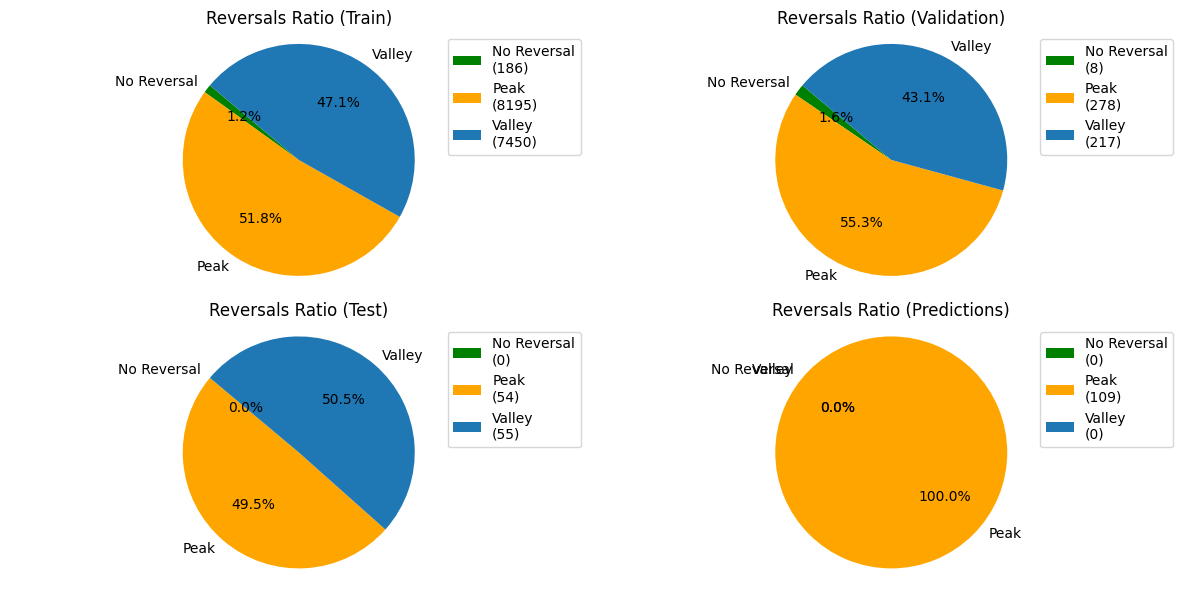

['Peak'] [0.49541284 0.        ] [1. 0.] [0.66257669 0.        ] [0. 1.] [1. 0.] [0. 1.] 0.4954128440366973


ValueError: All arrays must be of the same length

In [ ]:
evaluator = Evaluator(params)
results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset, test_dates, history, online_history, show=True)

In [ ]:
y_preds_max_indices = torch.argmax(y_preds, dim=-1)
y_test_max_indices = torch.argmax(y_test, dim=-1)

In [ ]:
# Convert tensors to numpy arrays
y_test_np = y_test_max_indices.numpy()
y_preds_np = y_preds_max_indices.numpy()

# Calculate metrics for each class
accuracy = accuracy_score(y_test_np, y_preds_np)
precision = precision_score(y_test_np, y_preds_np, average=None, zero_division=0)
recall = recall_score(y_test_np, y_preds_np, average=None, zero_division=0)
f1 = f1_score(y_test_np, y_preds_np, average=None, zero_division=0)

# Calculate confusion matrix
cm = confusion_matrix(y_test_np, y_preds_np)

# Extract True Positives, True Negatives, False Positives, False Negatives for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Calculate Specificity
specificity = np.where((TN + FP) != 0, TN / (TN + FP), 0)

# Calculate False Positive Rate
fpr = np.where((FP + TN) != 0, FP / (FP + TN), 0)

# Calculate False Negative Rate
fnr = np.where((FN + TP) != 0, FN / (FN + TP), 0)

# Calculate micro-averaging metrics
micro_precision = precision_score(y_test_np, y_preds_np, average='micro', zero_division=0)
micro_recall = recall_score(y_test_np, y_preds_np, average='micro', zero_division=0)
micro_f1 = f1_score(y_test_np, y_preds_np, average='micro', zero_division=0)

# Calculate macro-averaging metrics
macro_precision = precision_score(y_test_np, y_preds_np, average='macro', zero_division=0)
macro_recall = recall_score(y_test_np, y_preds_np, average='macro', zero_division=0)
macro_f1 = f1_score(y_test_np, y_preds_np, average='macro', zero_division=0)

# Create DataFrame to store metrics
# Create DataFrame to store metrics
unique_labels = np.unique(y_preds_np)
labels = ['No Reversal', 'Peak', 'Valley']
present_labels = [labels[i] for i in unique_labels]
if len(precision) ==  len(labels):
    present_labels == labels
confusion_metrics_info = pd.DataFrame({
    'Class': labels,
    'Accuracy': [accuracy]*len(labels),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity,
    'False Positive Rate': fpr,
    'False Negative Rate': fnr
})

# Add macro-averaging metrics
macro_avg_info = pd.DataFrame({
    'Class': ['Macro-average'],
    'Accuracy': [accuracy],
    'Precision': [macro_precision],
    'Recall': [macro_recall],
    'F1-Score': [macro_f1],
    'Specificity': [specificity],
    'False Positive Rate': [fpr],
    'False Negative Rate': [fnr]
})

# Add micro-averaging metrics
micro_avg_info = pd.DataFrame({
    'Class': ['Micro-average'],
    'Accuracy': [accuracy],
    'Precision': [micro_precision],
    'Recall': [micro_recall],
    'F1-Score': [micro_f1],
    'Specificity': [specificity],
    'False Positive Rate': [fpr],
    'False Negative Rate': [fnr]
})

confusion_metrics_info = pd.concat([confusion_metrics_info, macro_avg_info, micro_avg_info], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
# if save_path:
#     plt.savefig(save_path)
# if show:
#     plt.show()
# else:
#     plt.close()

# return confusion_metrics_info

ValueError: All arrays must be of the same length

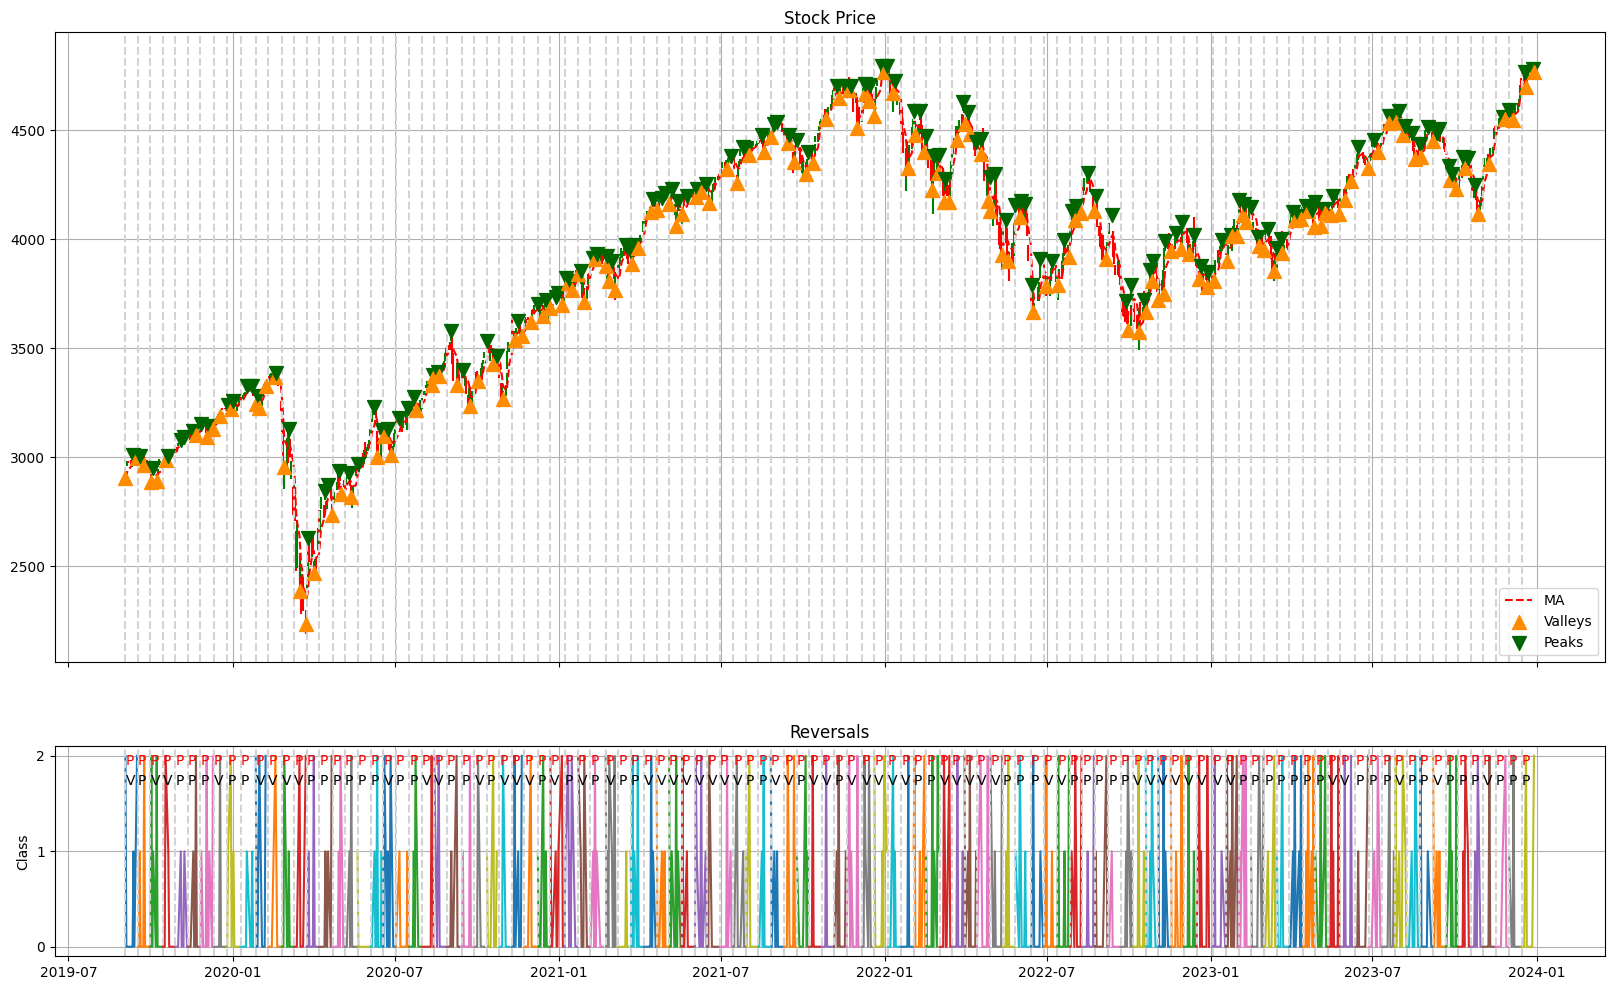

In [ ]:
evaluator.plot_stock_and_predictions(y_test_max_indices, y_preds_max_indices, test_dataset, test_dates,
                                        show=True, save_path=None)

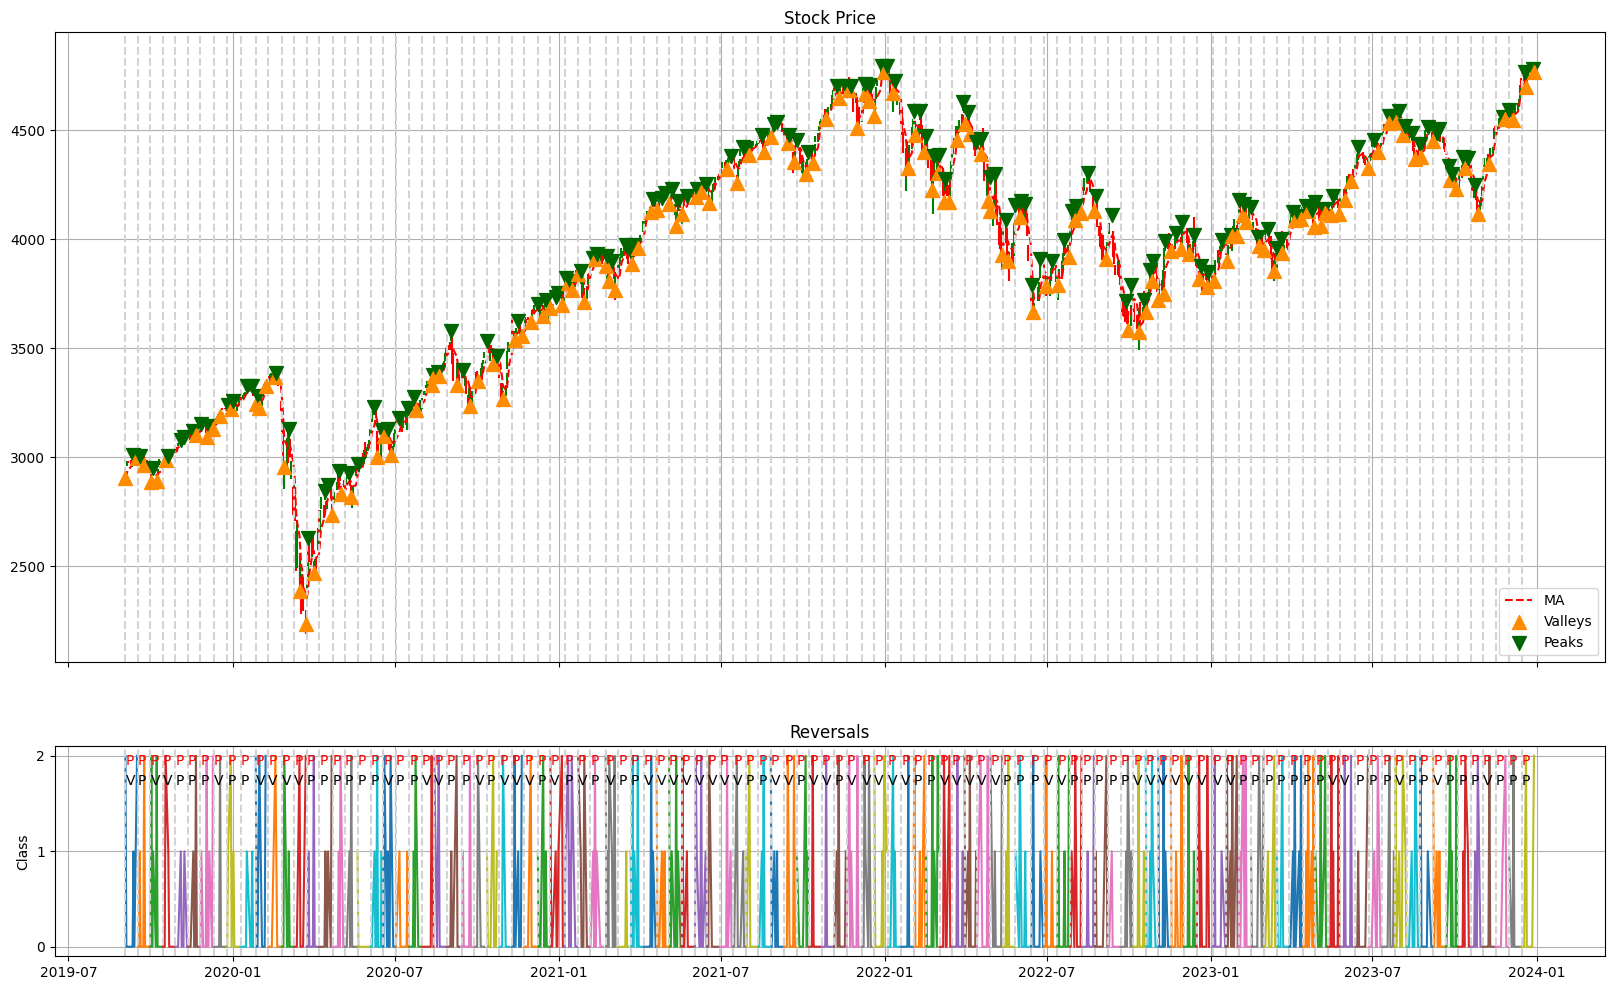

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

peaks_labeled = False
valleys_labeled = False
reversal_type = evaluator.params["features_params"][0]["local_type"]
for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
    if test_dataset['Reversals'].loc[idx] == 1:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
        peaks_labeled = True
    elif test_dataset['Reversals'].loc[idx] == 2:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
        valleys_labeled = True
ax[0].set_title('Stock Price')
ax[0].grid(True)
ax[0].legend()

y_test_label = evaluator._change_labels(y_test_max_indices, abbreviation=True)
y_preds_label = evaluator._change_labels(y_preds_max_indices, abbreviation=True)

for idx in range(test_dates.shape[0]):
    ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
    ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
    ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
    ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
    ax[1].annotate(f"{y_preds_label[idx]}", (test_dates[idx][0], 1.9), color='red', label='predicted')
ax[1].set_title('Reversals')
ax[1].set_ylabel('Class')
ax[1].set_yticks([0, 1, 2])
ax[1].grid(True)


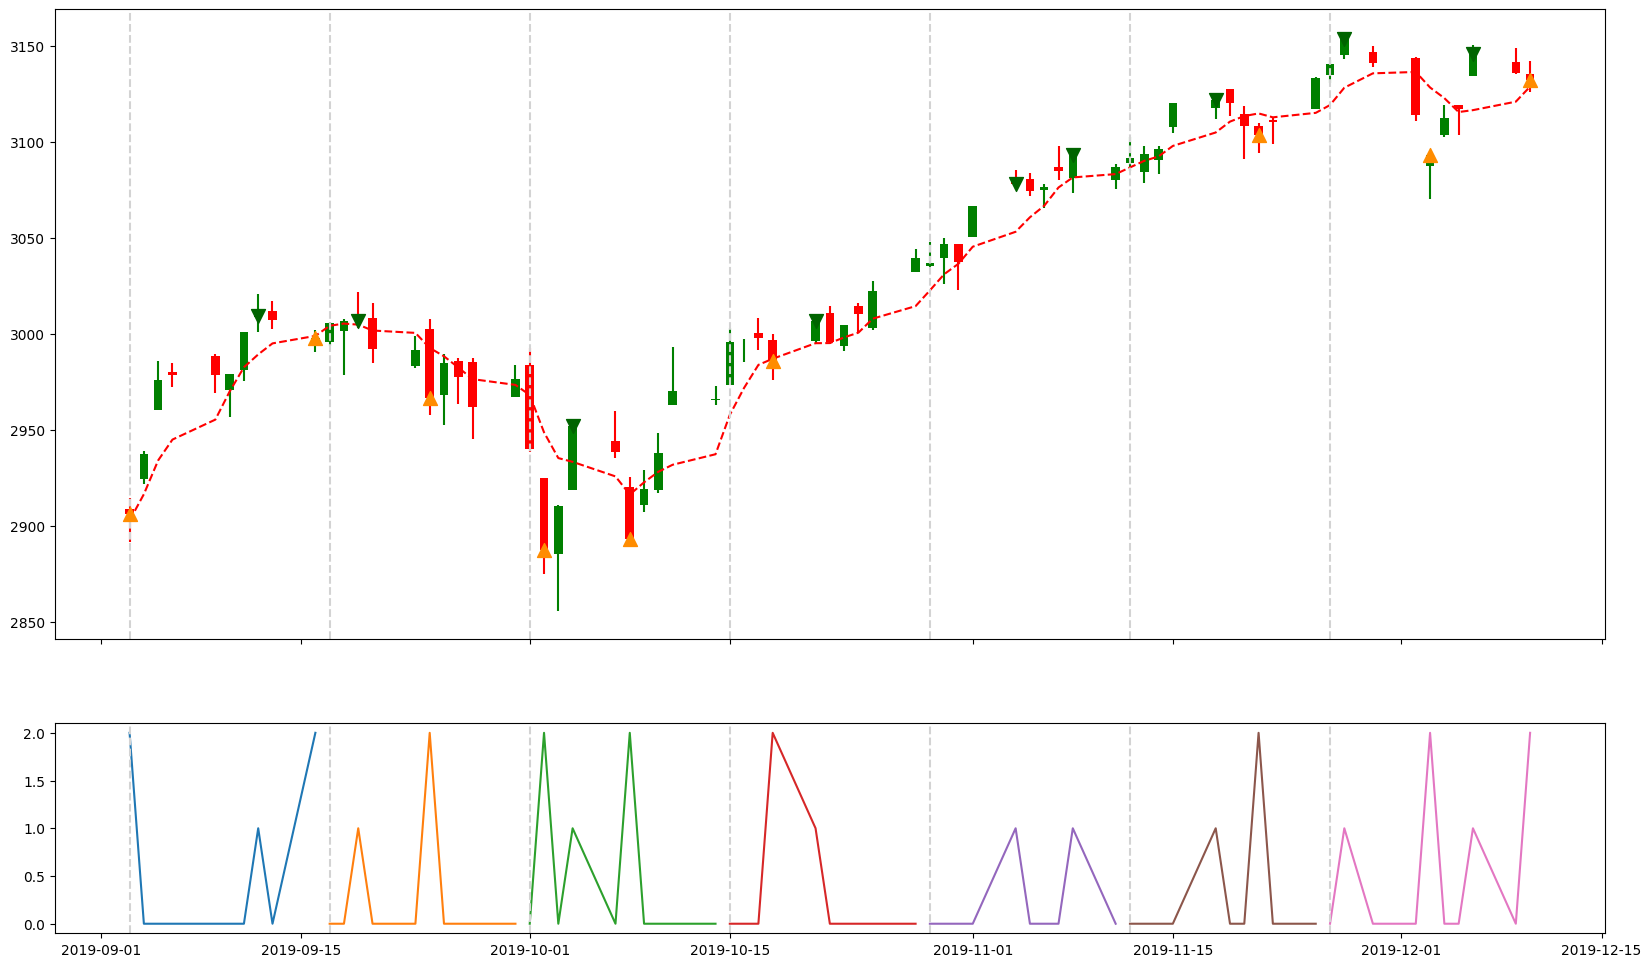

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

for idx in test_dataset.loc[test_dates[0][0]: test_dates[6][-1]].index:
    evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
    if test_dataset['Reversals'].loc[idx] == 1:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
        peaks_labeled = True
    elif test_dataset['Reversals'].loc[idx] == 2:
        ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
        valleys_labeled = True
        
ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[6][-1]], label='MA', color='red', linestyle='--')

for idx in range(0, 7):
    ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
    ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
    ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')

In [60]:
y_test_max_indices = torch.argmax(y_test, dim=-1)

In [61]:
low_point_price = None
sell_entry_point_price = None
low_counter = 0
for idx in test_dataset.loc[test_dates[1][0]: test_dates[1][-1]].index:
    if low_point_price == None:
        low_point_price = test_dataset['Close'].loc[idx]
    elif test_dataset['Close'].loc[idx] > low_point_price:
        low_point_price = test_dataset['Close'].loc[idx]
        low_counter += 1
    else:
        low_point_price = test_dataset['Close'].loc[idx]
        low_counter = 0
    if low_counter >= 2:
        if test_dataset['Low'].loc[idx] < low_point_price:
            sell_entry_point_price = low_point_price
            break

In [62]:
def find_sell_entry_point(test_dataset, start_date, end_date, rise_days_limit=2):
    current_check_point = None
    sell_price = None
    consecutive_rise_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_low = test_dataset['Low'].loc[idx]
        
        if current_check_point is None:
            current_check_point = current_close
        elif current_close > current_check_point:
            current_check_point = current_close
            consecutive_rise_days += 1
        else:
            current_check_point = current_close
            consecutive_rise_days = 0
        
        if consecutive_rise_days >= rise_days_limit:
            if current_low < current_check_point:
                sell_price = current_check_point
                # print(f"Sell at {sell_price} on {idx}")
                return sell_price, idx
    return sell_price, None


In [63]:
def find_buy_entry_point(test_dataset, start_date, end_date, drop_days_limit=2):
    current_check_point = None
    buy_price = None
    consecutive_drop_days = 0

    date_range = test_dataset.loc[start_date: end_date].index

    for idx in date_range:
        current_close = test_dataset['Close'].loc[idx]
        current_high = test_dataset['High'].loc[idx]
        
        if current_check_point is None:
            current_check_point = current_close
        elif current_close < current_check_point:
            current_check_point = current_close
            consecutive_drop_days += 1
        else:
            current_check_point = current_close
            consecutive_drop_days = 0
        
        if consecutive_drop_days >= drop_days_limit:
            if current_high > current_check_point:
                buy_price = current_check_point
                # print(f"Buy at {buy_price} on {idx}")
                return buy_price, idx
    return buy_price, None
        

In [64]:
sell_points = []
buy_points = []
for idx in range(0, y_test_max_indices.shape[0]):
    if y_test_max_indices[idx] == 1:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            sell_price, date = find_sell_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        sell_points.append((sell_price, date))
        if sell_price is not None:
            buy_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else: 
            buy_points.append((None, None))
    if y_test_max_indices[idx] == 2:
        if idx > 0 and idx < y_test_max_indices.shape[0]-1:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx-1][-1], test_dates[idx+1][1])
        else:
            buy_price, date = find_buy_entry_point(test_dataset, test_dates[idx][0], test_dates[idx][-1])
        buy_points.append((buy_price, date))
        if buy_price is not None:
            sell_points.append((test_dataset['Open'].iloc[test_dataset.index.get_loc(date)+3], test_dataset.iloc[test_dataset.index.get_loc(date)+3].name))
        else:
            sell_points.append((None, None))
    else:
        buy_points.append((None, None))
        sell_points.append((None, None))

In [65]:
buy_amount = 0
sell_amount = 0
buy_amount += sum([buy_point[0] for buy_point in buy_points if buy_point[0] is not None])
sell_amount += sum([sell_point[0] for sell_point in sell_points if sell_point[0] is not None])

In [66]:
sum(1 for point in buy_points if point[0] is not None)

75

In [67]:
sum(1 for point in sell_points if point[0] is not None)

75

In [68]:
buy_amount - sell_amount

-2.4326953887939453

In [69]:
buy_amount = 0
sell_amount = 0
for i in range(len(buy_points)):
    try: 
        if buy_points[i][0] is not None:
            buy_amount += buy_points[i][0]
        if sell_points[i][0] is not None:
            sell_points += sell_points[i][0]
    except:
        print(i, buy_points[i][0], sell_points[i][0])

0 29.303499221801758 29.33679962158203
1 29.246999740600586 29.281999588012695
2 29.0049991607666 29.20599937438965
3 28.77199935913086 28.835599899291992
5 28.658700942993164 28.77199935913086
7 28.531299591064453 28.586999893188477
8 28.46739959716797 28.51300048828125
9 28.441699981689453 28.51799964904785
11 28.11199951171875 28.128000259399414
12 27.93899917602539 28.06999969482422
13 28.017000198364258 28.017000198364258
15 27.863000869750977 27.90290069580078
17 28.009700775146484 27.973600387573242
19 27.739999771118164 27.934099197387695
20 28.000999450683594 28.283000946044922
22 28.501300811767578 28.48069953918457
24 28.374000549316406 28.530500411987305
26 28.025999069213867 28.031999588012695
27 27.885000228881836 27.731300354003906
28 27.960500717163086 28.05419921875
30 27.516700744628906 27.631500244140625
31 27.561199188232422 27.7810001373291
32 27.865800857543945 27.840499877929688
33 27.972000122070312 28.01919937133789
35 27.898000717163086 28.018299102783203
37 2

In [70]:
test_dataset_copy = test_dataset.copy()
test_dataset_copy['Reversals_trade'] = 0

In [71]:
for info in buy_points:
    if info[0] is not None:
        test_dataset_copy['Reversals_trade'].loc[info[1]] = 2
        
for info in sell_points:
    if info[0] is not None:
        test_dataset_copy['Reversals_trade'].loc[info[1]] = 1

/tmp/ipykernel_110904/2446330195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset_copy['Reversals_trade'].loc[info[1]] = 2
/tmp/ipykernel_110904/2446330195.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset_copy['Reversals_trade'].loc[info[1]] = 1


In [72]:
test_dataset_copy = test_dataset_copy.loc[test_dates[0][0]: test_dates[-1][-1]]

In [73]:
test_dataset_copy['Reversals_trade'].value_counts()

0    728
2     72
1     70
Name: Reversals_trade, dtype: int64

In [74]:
test_dataset_copy['Reversals'].value_counts()

0    602
1    135
2    133
Name: Reversals, dtype: int64

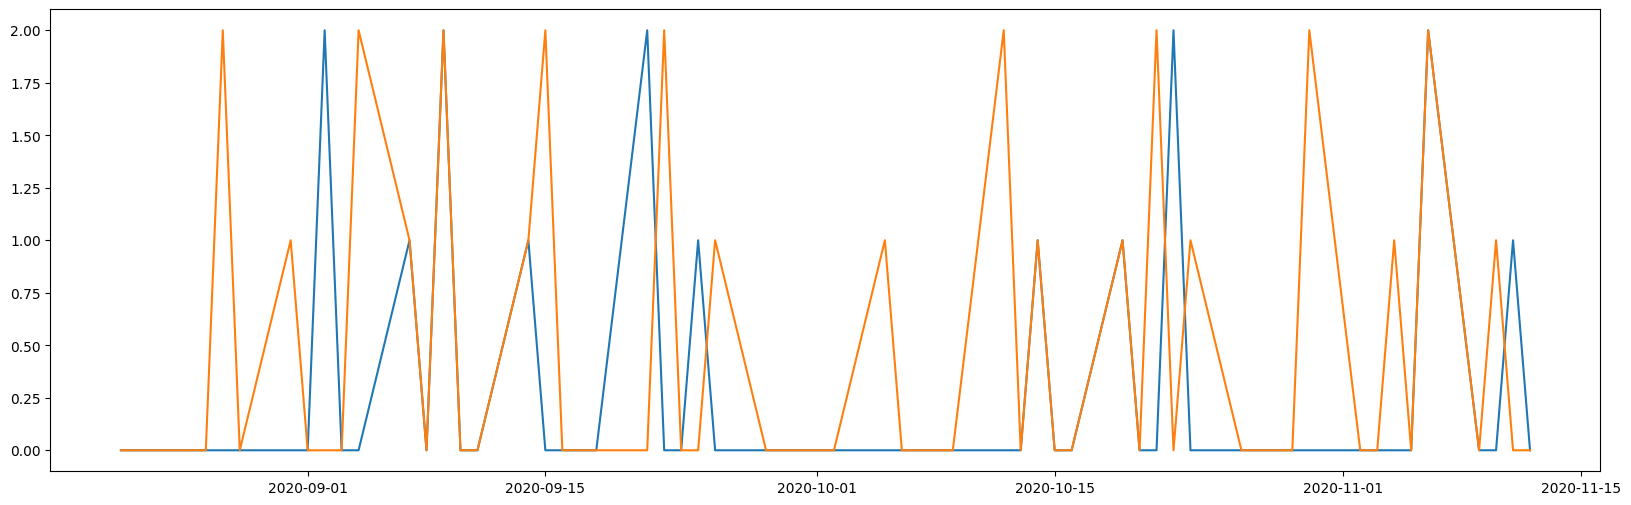

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(test_dataset_copy['Reversals_trade'].loc[test_dates[0][0]: test_dates[5][-1]])
plt.plot(test_dataset_copy['Reversals'].loc[test_dates[0][0]: test_dates[5][-1]])

In [76]:
i = 0
buy_points[i:i+1]


[(29.303499221801758, Timestamp('2020-09-02 00:00:00'))]

In [77]:
sell_points[i:i+1]


[(29.33679962158203, Timestamp('2020-09-07 00:00:00'))]

In [78]:
test_dates[i]

array(['2020-08-21T00:00:00.000000000', '2020-08-24T00:00:00.000000000',
       '2020-08-25T00:00:00.000000000', '2020-08-26T00:00:00.000000000',
       '2020-08-27T00:00:00.000000000', '2020-08-28T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-09-02T00:00:00.000000000', '2020-09-03T00:00:00.000000000'],
      dtype='datetime64[ns]')

NameError: name 'evaluator' is not defined

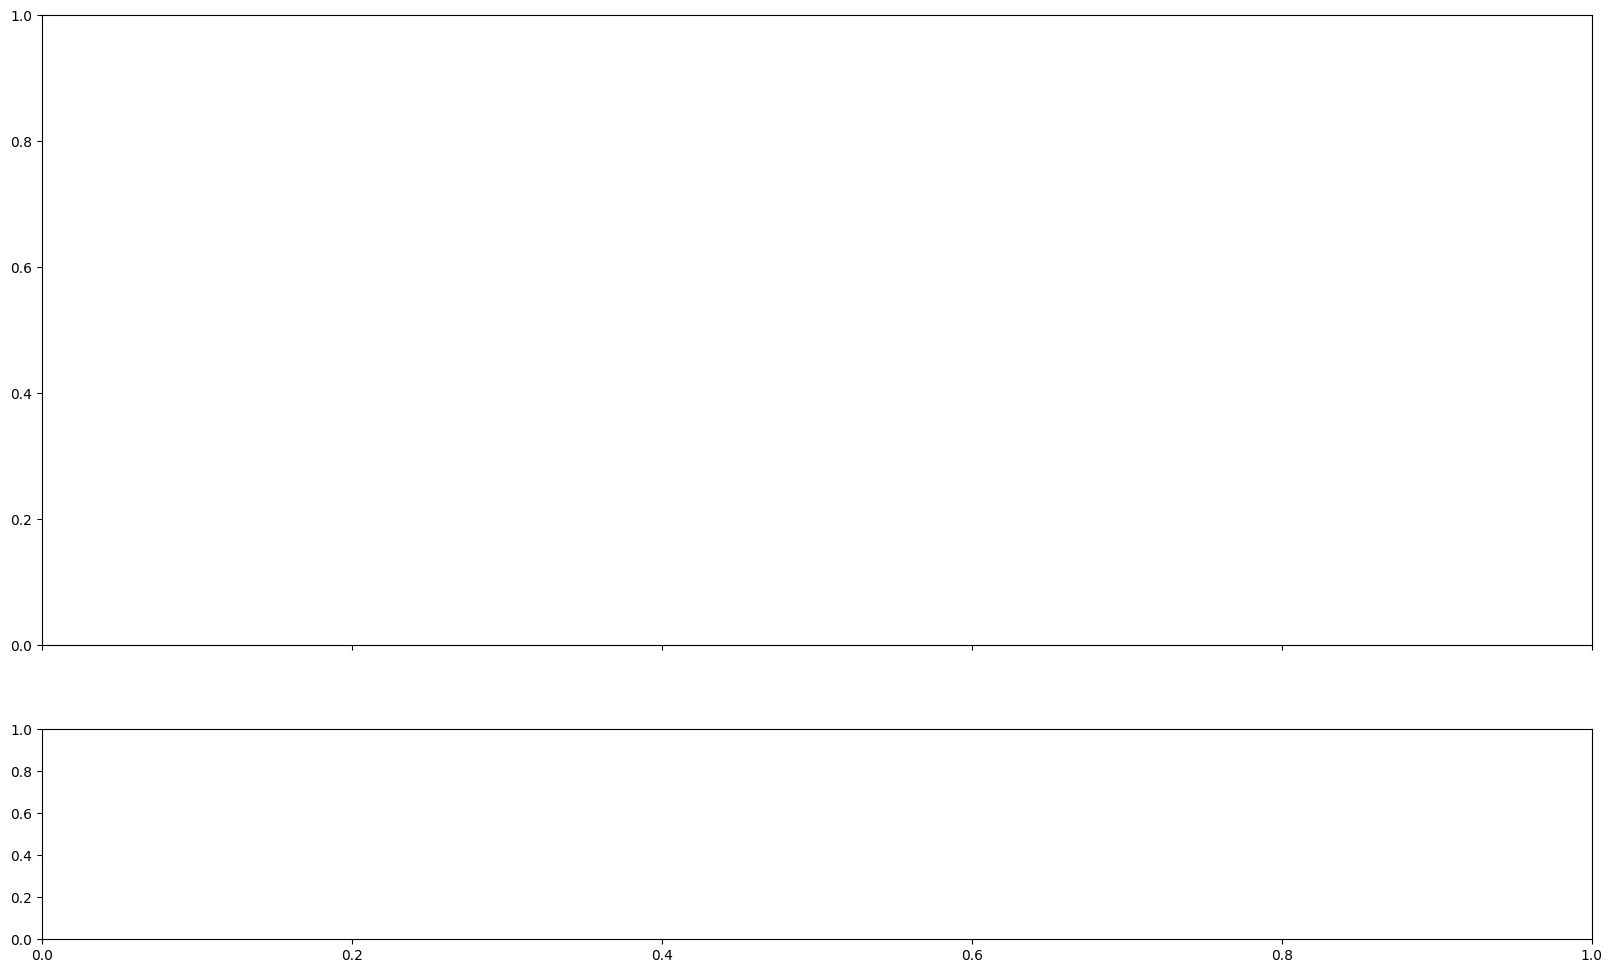

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

for idx in test_dataset.loc[test_dates[0][0]: test_dates[10][-1]].index:
    evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
    # if test_dataset['Reversals'].loc[idx] == 1:
    #     ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
    #     peaks_labeled = True
    # elif test_dataset['Reversals'].loc[idx] == 2:
    #     ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
    #     valleys_labeled = True
        
ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[10][-1]], label='MA', color='red', linestyle='--')

for idx in range(0, 10):
    ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
    ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
    ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
    
for info in sell_points[0:10]:
    if info[0] is not None and info[1] is not None:
        ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
        
for info in buy_points[0:10]:
    if info[0] is not None and info[1] is not None:
        ax[0].scatter(info[1], info[0], color='black', label='Buy', zorder=10, marker='^', s=200)
plt.show()

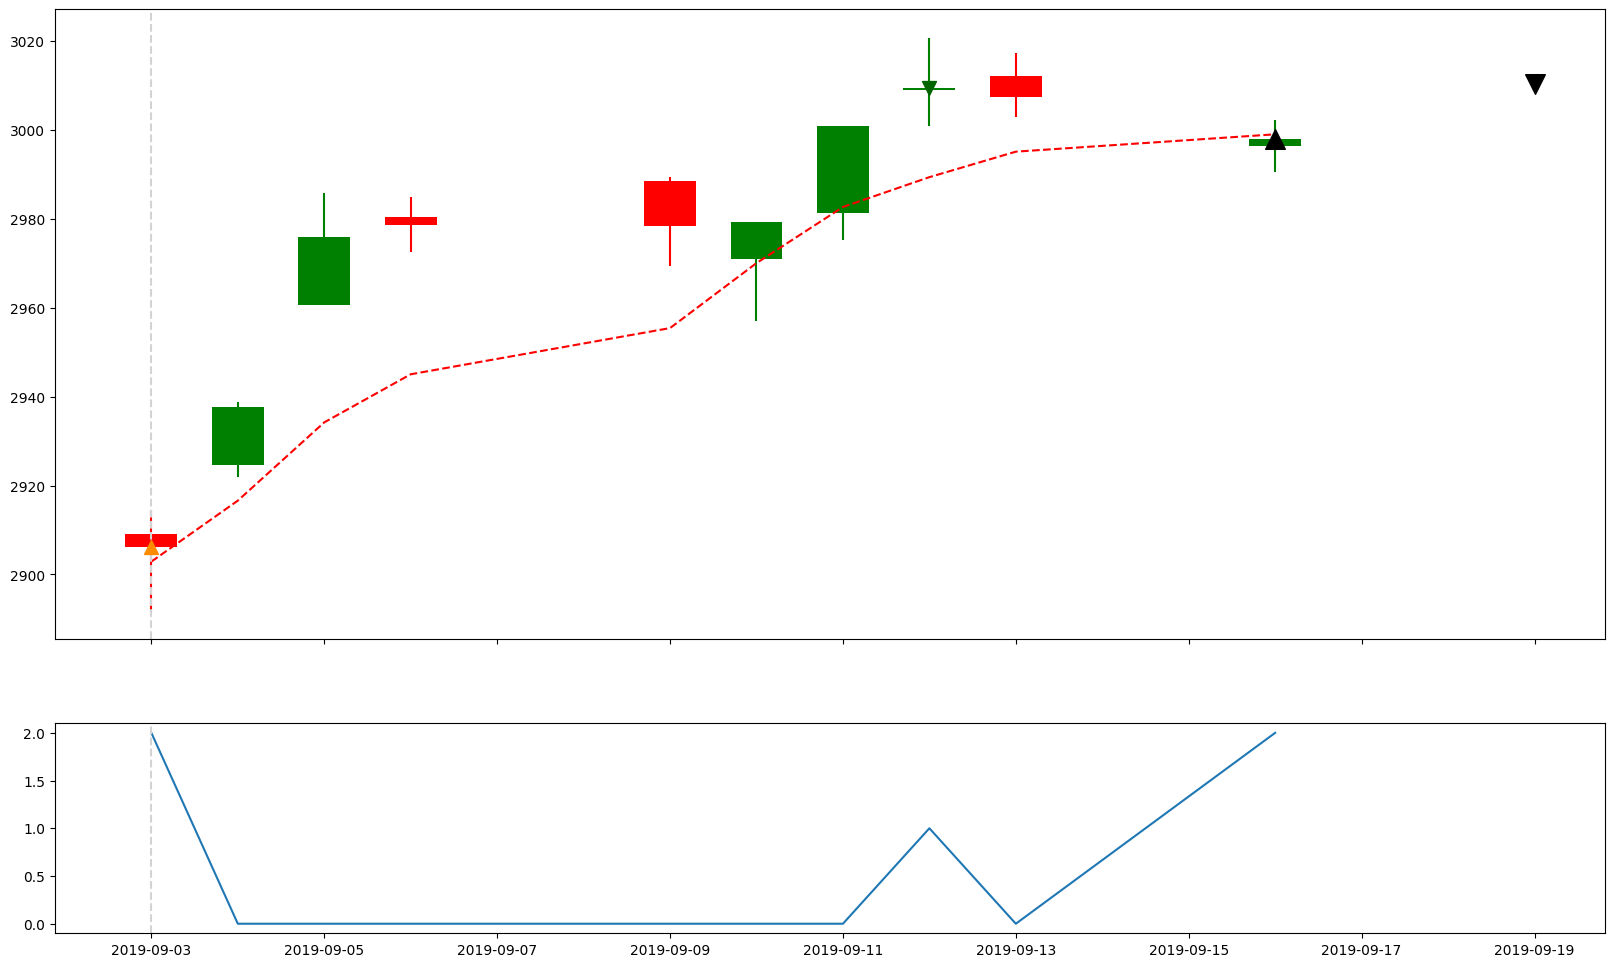

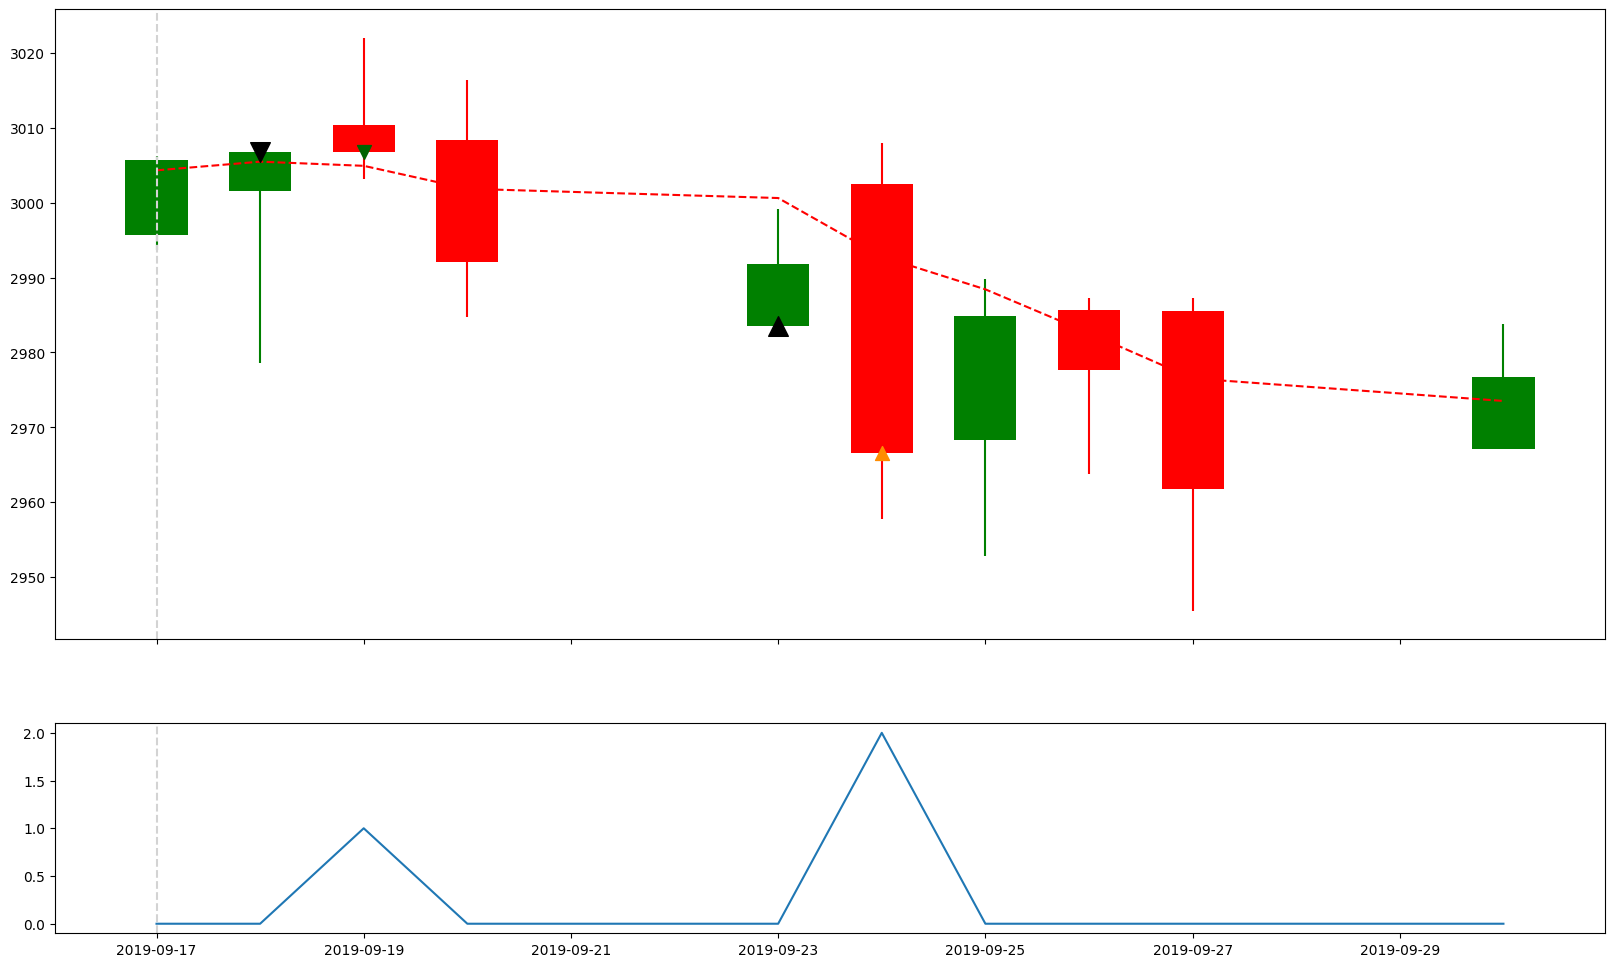

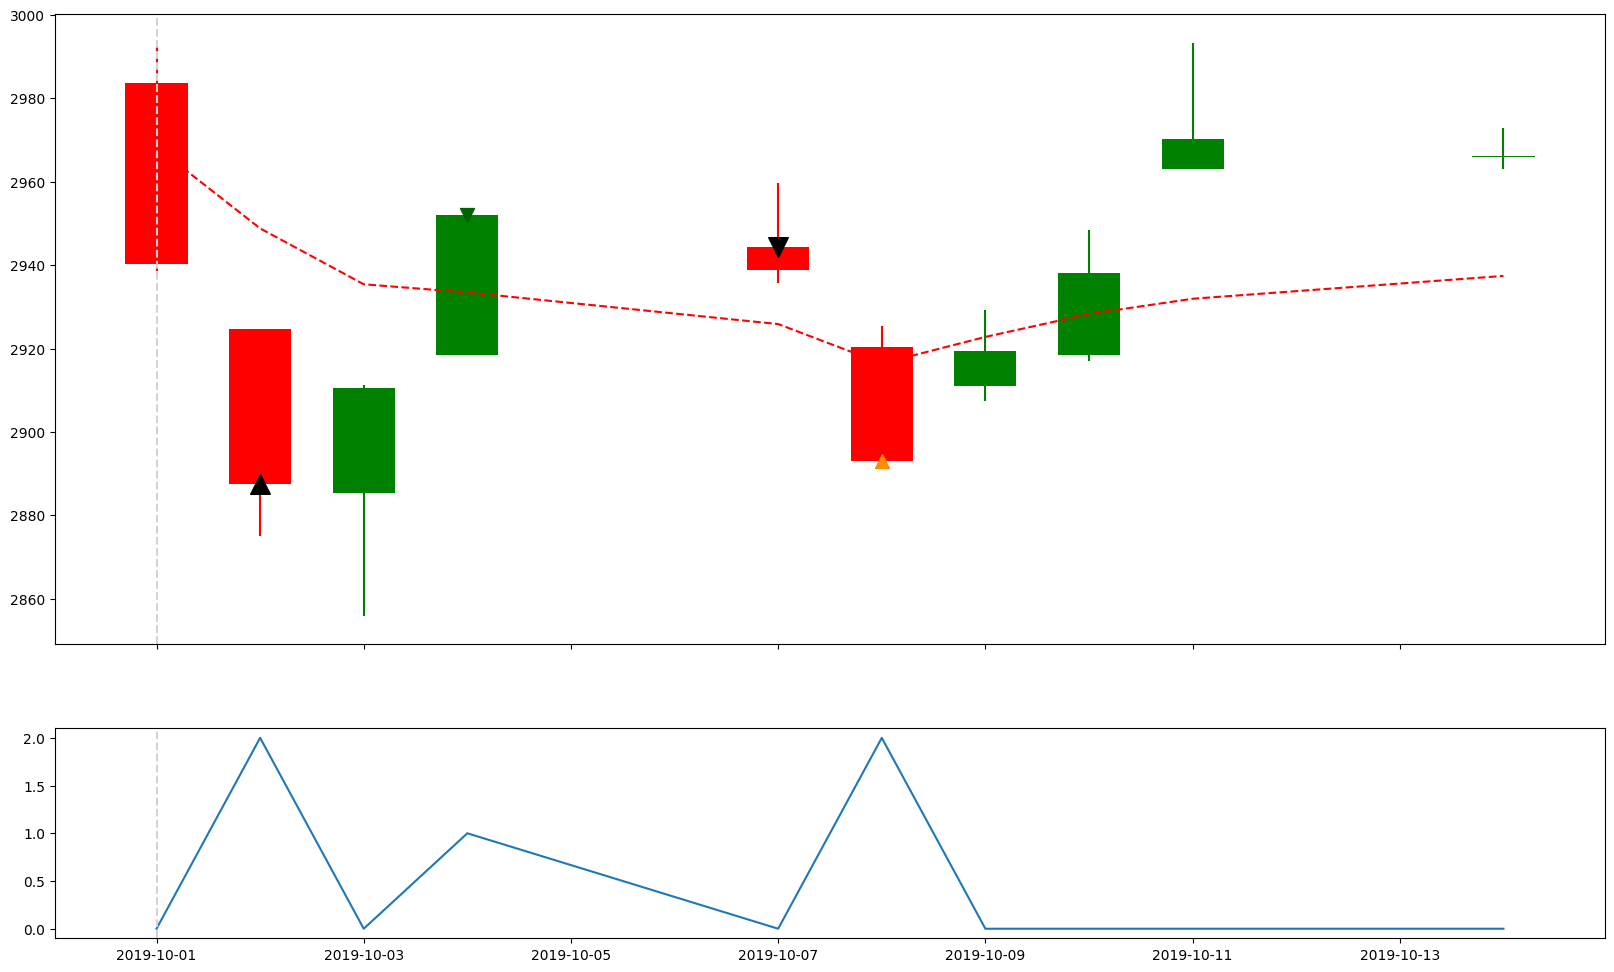

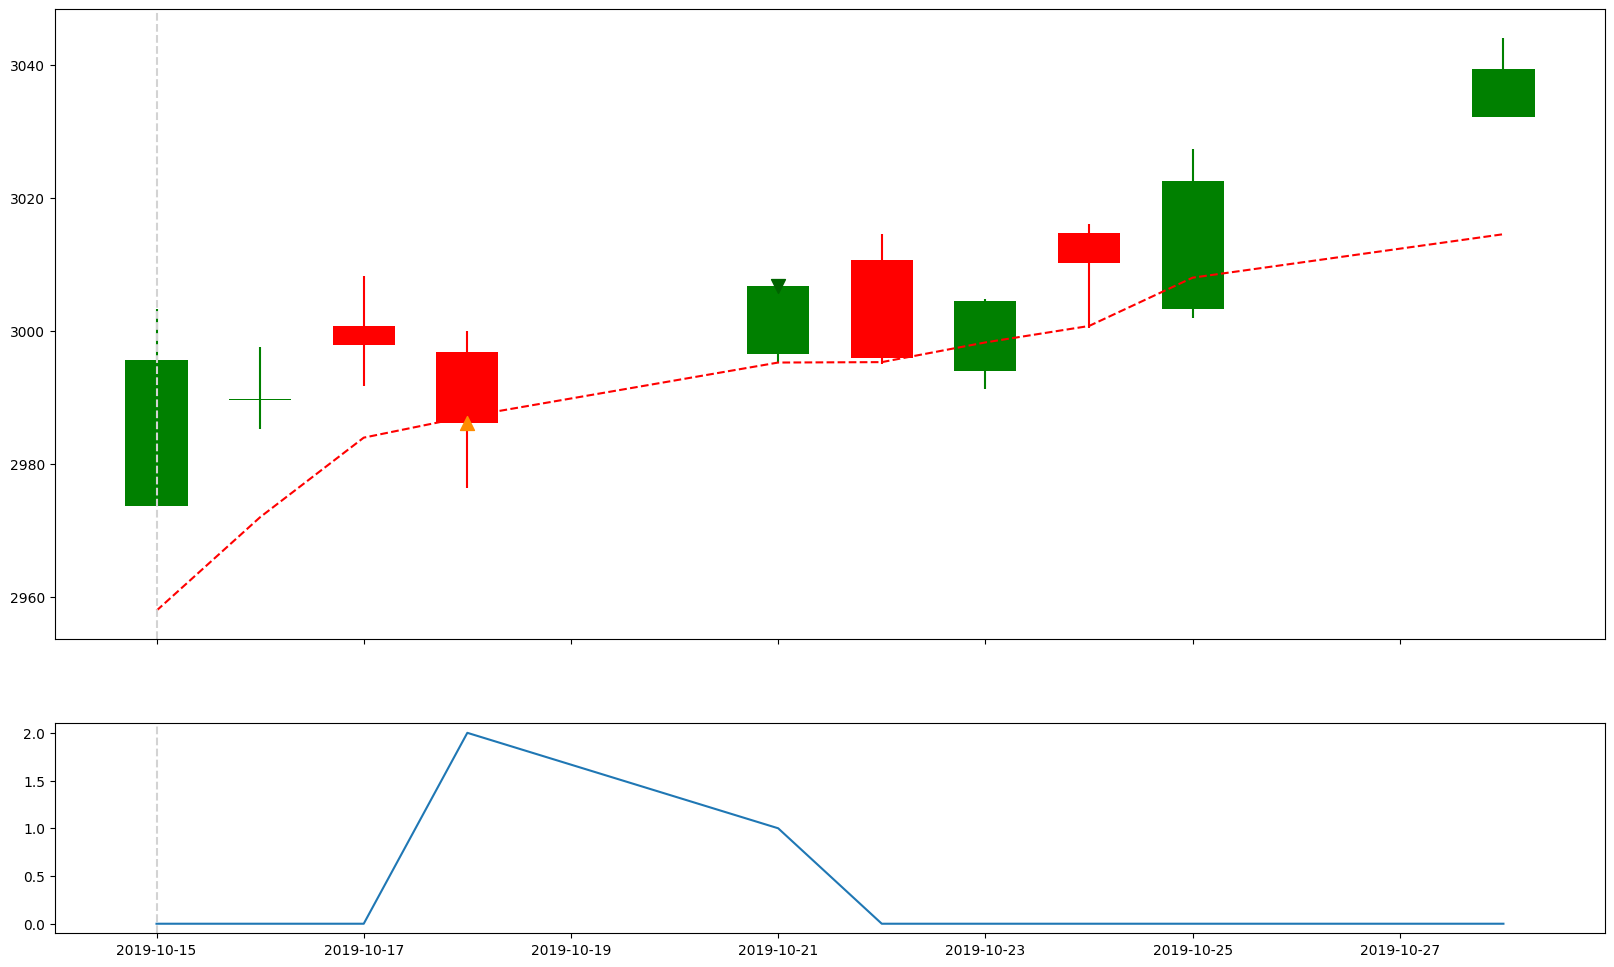

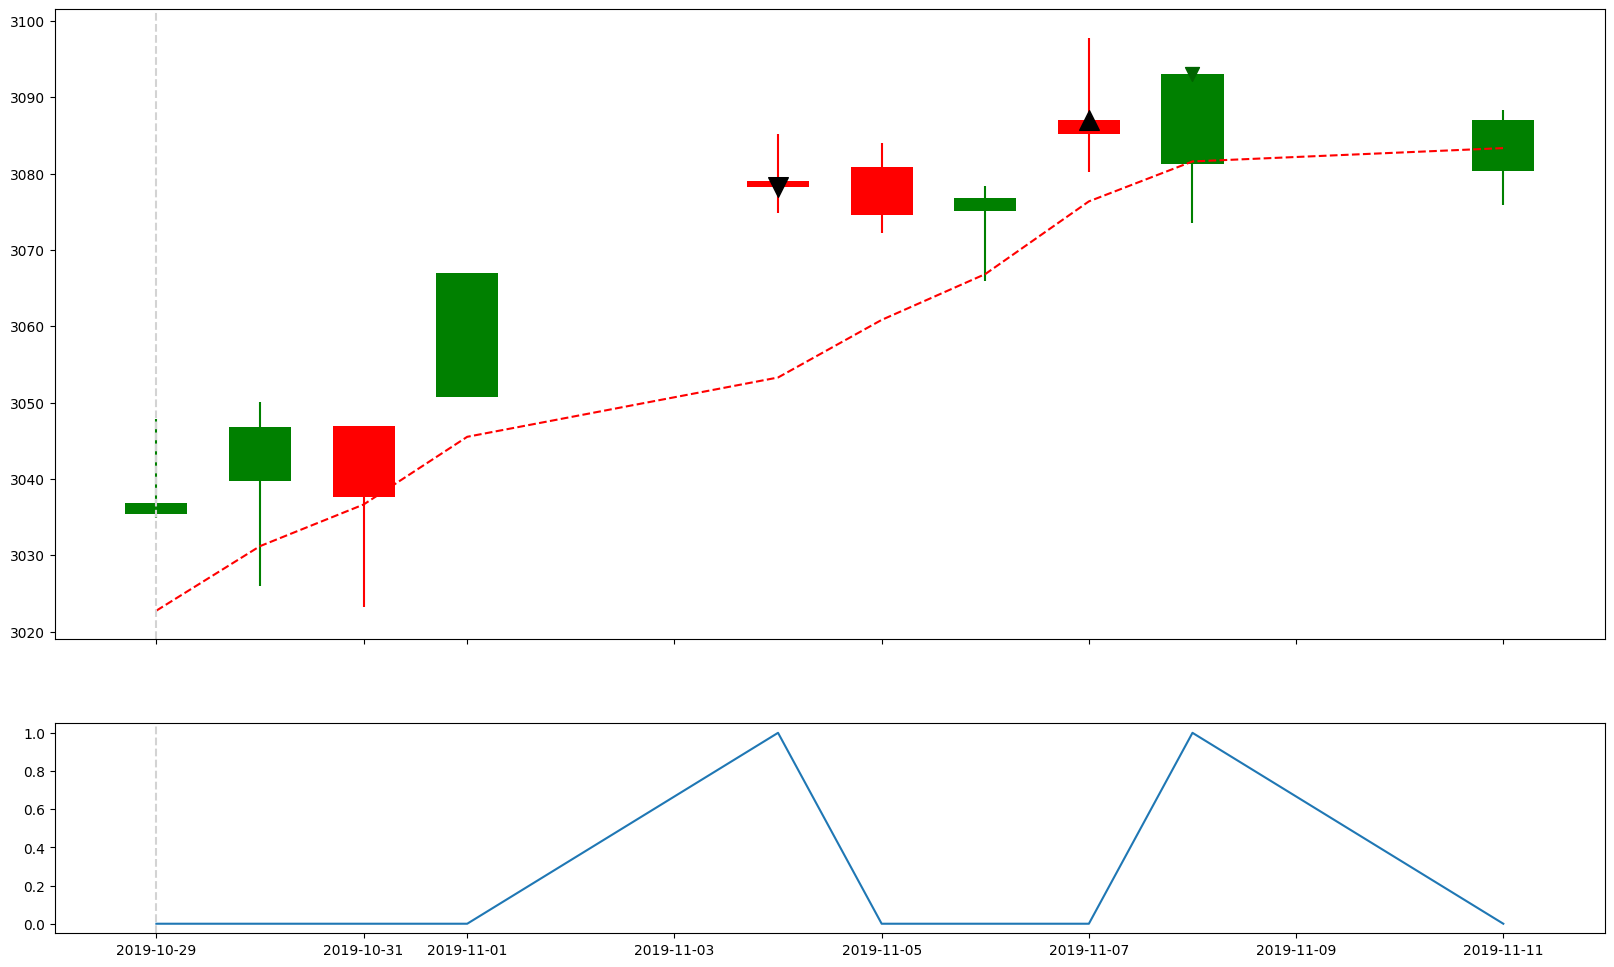

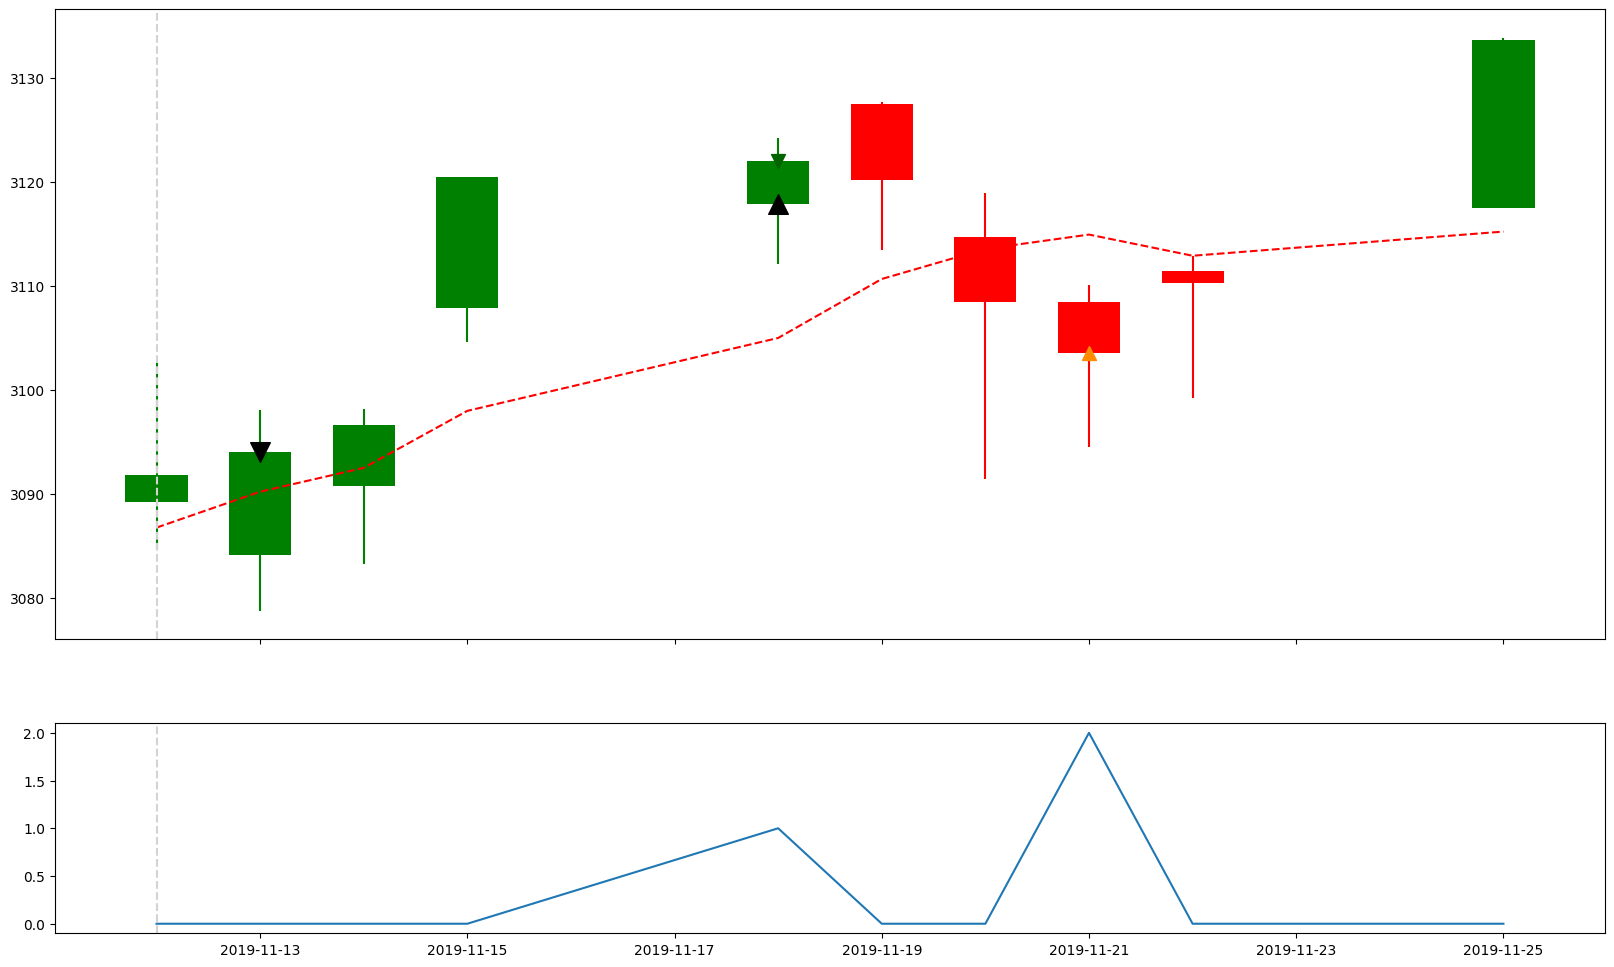

KeyboardInterrupt: 

In [ ]:
for i in range(test_dates.shape[0]):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

    for idx in test_dataset.loc[test_dates[i][0]: test_dates[i][-1]].index:
        evaluator._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
        if test_dataset['Reversals'].loc[idx] == 1:
            ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5, marker='v', s=100)
            peaks_labeled = True
        elif test_dataset['Reversals'].loc[idx] == 2:
            ax[0].scatter(idx, test_dataset.loc[idx][reversal_type], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5, marker='^', s=100)
            valleys_labeled = True
            
    ax[0].plot(test_dataset['MA'].loc[test_dates[i][0]: test_dates[i][-1]], label='MA', color='red', linestyle='--')

    for idx in range(i, i+1):
        ax[1].plot(test_dataset['Reversals'].loc[test_dates[idx]])
        ax[0].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        ax[1].axvline(x=test_dates[idx][0], color='lightgray', linestyle='--')
        
    for info in sell_points[i:i+1]:
        if info[0] is not None and info[1] is not None:
            ax[0].scatter(info[1], info[0], color='black', label='Sell', zorder=10, marker='v', s=200)
            
    for info in buy_points[i:i+1]:
        if info[0] is not None and info[1] is not None:
            ax[0].scatter(info[1], info[0], color='black', label='Buy', zorder=10, marker='^', s=200)
    plt.show()

In [ ]:
sell_entry_point_price

3006.7900390625

In [ ]:
high_point_price = None
buy_entry_point_price = None
high_counter = 0
for idx in test_dataset.loc[test_dates[5][0]: test_dates[5][-1]].index:
    if high_point_price == None:
        high_point_price = test_dataset['Close'].loc[idx]
    elif test_dataset['Close'].loc[idx] < high_point_price:
        high_point_price = test_dataset['Close'].loc[idx]
        high_counter += 1
    else:
        high_point_price = test_dataset['Close'].loc[idx]
        high_counter = 0
    if high_counter >= 2:
        if test_dataset['High'].loc[idx] > high_point_price:
            buy_entry_point_price = high_point_price
            break
    print(test_dataset['Close'].loc[idx], high_point_price, high_counter)

3091.840087890625 3091.840087890625 0
3094.0400390625 3094.0400390625 0
3096.6298828125 3096.6298828125 0
3120.4599609375 3120.4599609375 0
3122.030029296875 3122.030029296875 0
3120.179931640625 3120.179931640625 1


In [ ]:
high_counter

2

In [ ]:
buy_entry_point_price

3108.4599609375

In [ ]:
test_dataset.loc[test_dates[1][0]: test_dates[1][-1]]

,Open,High,Low,Close,Adj Close,Volume,Reversals,MACD_dif,MACD_dem,MACD_histogram,...,30Y Treasury Yield,upperband,middleband,lowerband,ATR,OBV,Parabolic SAR,MOM,Williams %R,Chaikin MF
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-17,2995.669922,3006.209961,2993.729980,3005.699951,3005.699951,3673250000,0,15.867751,16.329197,-0.461445,...,2.280,3043.207365,2942.982471,2842.757577,30.468070,1.064049e+12,2936.119506,99.429932,-8.968957,8.176455e+09
2019-09-18,3001.500000,3007.830078,2978.570068,3006.729980,3006.729980,3458800000,0,14.135041,15.890365,-1.755324,...,2.236,3050.196215,2948.293469,2846.390724,30.381780,1.067508e+12,2946.273964,68.949951,-10.869751,9.488456e+09
2019-09-19,3010.360107,3021.989990,3003.159912,3006.790039,3006.790039,3265660000,1,12.342357,15.180764,-2.838407,...,2.213,3056.751370,2952.411475,2848.071579,29.556659,1.070773e+12,2955.209887,30.790039,-11.679702,8.817981e+09
2019-09-20,3008.419922,3016.370117,2984.679932,2992.070068,2992.070068,6103440000,0,8.386209,13.821853,-5.435644,...,2.199,3060.652987,2955.867480,2851.081974,29.709053,1.064670e+12,2964.559102,13.360107,-22.990584,6.776539e+09
2019-09-23,2983.500000,2999.149902,2982.229980,2991.780029,2991.780029,3187250000,0,5.676110,12.192704,-6.516594,...,2.154,3056.176309,2963.100977,2870.025644,28.795544,1.061483e+12,2972.599426,13.350098,-30.170774,5.696566e+09
2019-09-24,3002.429932,3007.979980,2957.729980,2966.600098,2966.600098,3872800000,2,0.038726,9.761909,-9.723183,...,2.095,3052.082109,2967.511987,2882.941866,30.328005,1.057610e+12,3021.989990,-12.789795,-85.241473,3.922592e+09
2019-09-25,2968.350098,2989.820068,2952.860107,2984.870117,2984.870117,3331200000,0,-0.270373,7.755452,-8.025825,...,2.184,3045.018148,2973.297498,2901.576847,30.801716,1.060941e+12,3020.704790,-16.059814,-53.695843,3.920472e+09
2019-09-26,2985.729980,2987.280029,2963.709961,2977.620117,2977.620117,3084910000,0,-1.521071,5.900148,-7.421219,...,2.128,3037.864623,2977.781506,2917.698390,30.285170,1.057856e+12,3017.991003,-31.949951,-64.183348,3.957986e+09
2019-09-27,2985.469971,2987.310059,2945.530029,2961.790039,2961.790039,3246480000,0,-4.509580,3.818202,-8.327782,...,2.124,3035.150581,2979.642004,2924.133427,31.106231,1.054610e+12,3015.385767,-45.599854,-78.733955,3.495239e+09


In [ ]:
sell_entry_point_price

3006.7900390625